Analysing data from 5 years: [2021, 2022, 2023, 2024, 2025]
Menampilkan grafik di layar...


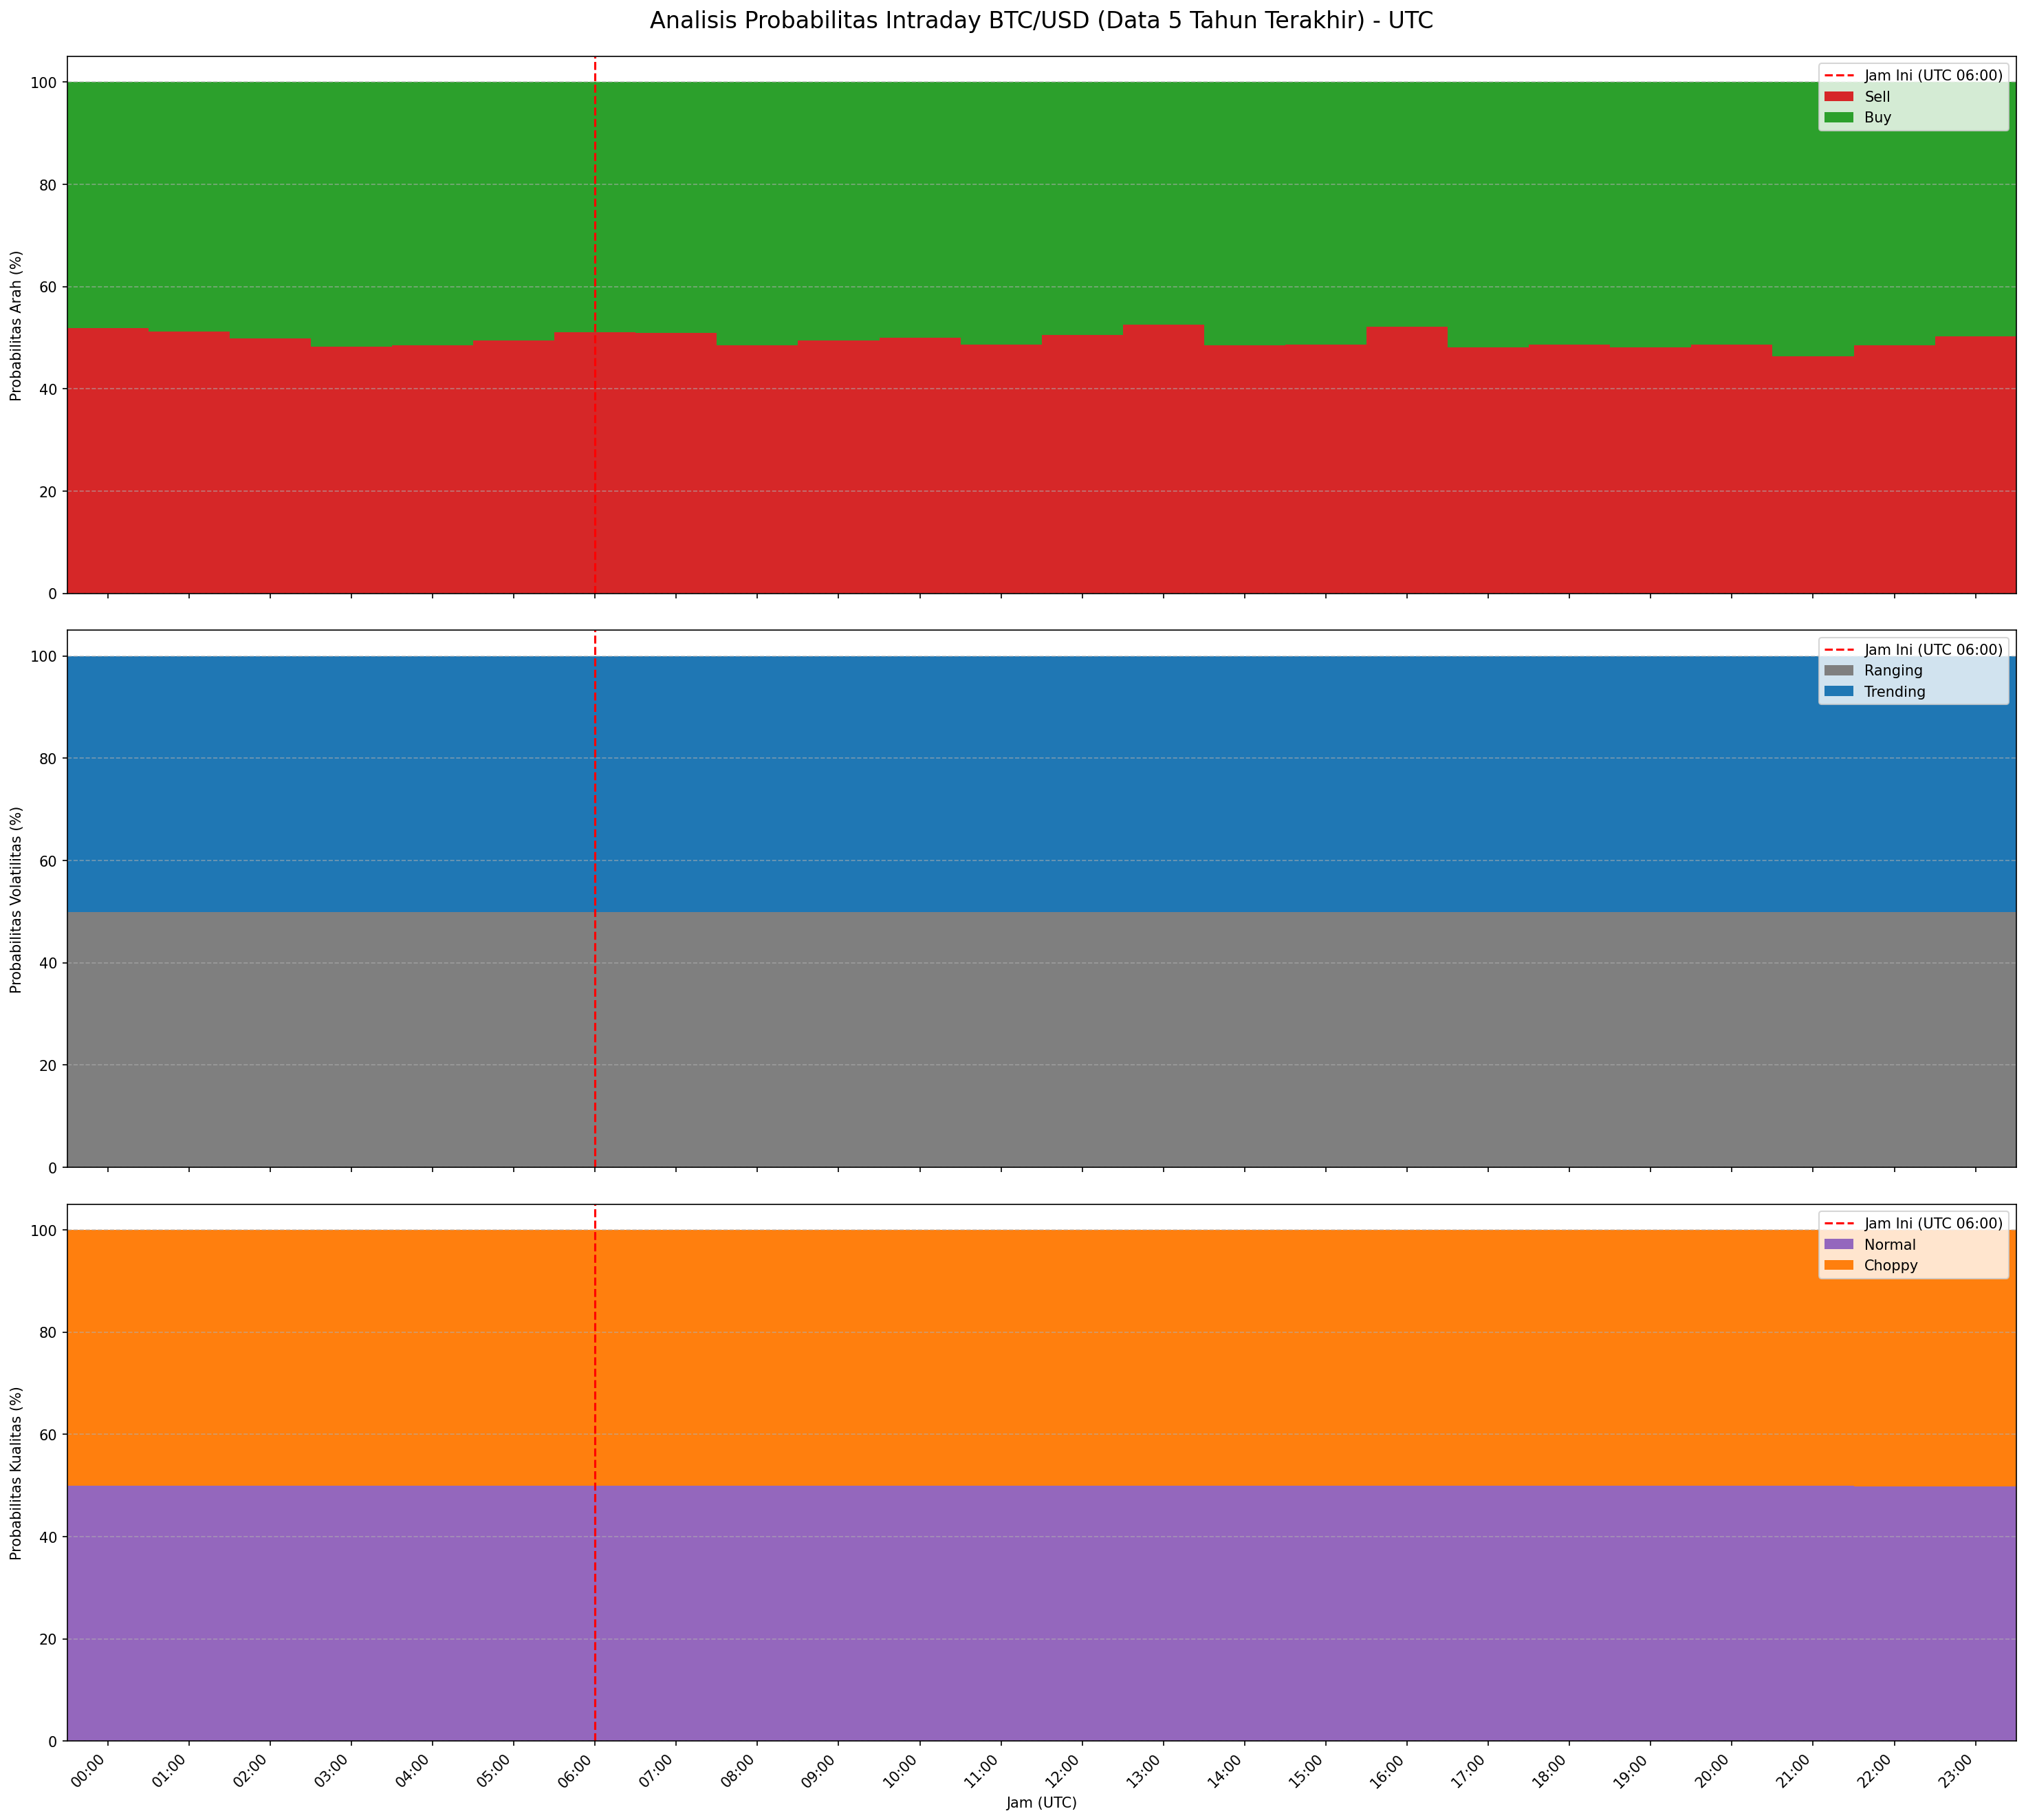


📊 Analisis Probabilitas Intraday BTC/USD
📅 Tanggal & Waktu Analisis: 22 June 2025, 06:55:47 UTC

Ringkasan Probabilitas untuk Jam Ini (UTC 06:00)
Berdasarkan data historis 5 tahun terakhir:

--- 1. Probabilitas Arah ---
  🟢 Kecenderungan Buy      : 48.96%
  🔴 Kecenderungan Sell     : 51.04%
-------------------------

--- 2. Probabilitas Volatilitas ---
  🔵 Kecenderungan Trending : 50.07%
  ⚪ Kecenderungan Ranging  : 49.93%
-------------------------

--- 3. Probabilitas Kualitas ---
  🟠 Kecenderungan Choppy   : 50.07%
  🟣 Kecenderungan Normal   : 49.93%
-------------------------


Ringkasan juga telah disimpan ke file: Seasonal Data Intraday/2025-06-22_06-55-47-BTCUSD_H1_202107022100_202506192100 - intraday_summary.txt


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
from zoneinfo import ZoneInfo

# --- 1. Pengaturan Awal (Folder & Nama File) ---
# Set time zone to UTC as requested for intraday analysis
zona_waktu_utc = ZoneInfo("UTC") 

# IMPORTANT: Please ensure this file exists and contains hourly data
# with columns <DATE>, <TIME>, <OPEN>, <HIGH>, <LOW>, <CLOSE>, <VOL>
input_csv_filename = "BTCUSD_H1_202107022100_202506192100.csv" 

# Get current UTC time for summary and dynamic filename
now_utc = datetime.now(zona_waktu_utc)
now_utc_str = now_utc.strftime('%Y-%m-%d_%H-%M-%S')
output_folder = "Seasonal Data Intraday"

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Output filename for the summary text
summary_txt_filename = f"{now_utc_str}-{input_csv_filename.replace('.csv','')} - intraday_summary.txt"
summary_txt_filepath = os.path.join(output_folder, summary_txt_filename)

# --- 2. Muat & siapkan data ---
try:
    # Assuming space-delimited data with DATE and TIME columns
    df = pd.read_csv(input_csv_filename, delim_whitespace=True)
except FileNotFoundError:
    print(f"Error: Pastikan file '{input_csv_filename}' berada di direktori yang sama.")
    exit()

# Clean column names (remove '<>' symbols)
df.columns = [c.strip('<>') for c in df.columns]

# Combine DATE and TIME columns into a single datetime object
# Ensure the format matches your CSV. '%Y.%m.%d %H:%M' is common for combined datetime.
df['DATETIME_UTC'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'], format='%Y.%m.%d %H:%M', utc=True)
df.set_index('DATETIME_UTC', inplace=True)
df.dropna(inplace=True)

# Extract hour of the day (0-23 UTC)
df['hour_of_day_utc'] = df.index.hour
# Extract year for filtering (if needed, to select latest years)
df['year'] = df.index.year

# --- 3. Hitung metrik turunan & klasifikasikan rezim ---
# 'direction' based on intraday candle close vs open
df['direction'] = np.where(df['CLOSE'] > df['OPEN'], 'Buy', 'Sell')
# 'range_body' based on intraday candle body
df['range_body'] = (df['CLOSE'] - df['OPEN']).abs()

def classify_regimes(group):
    """
    Classifies volatility and quality regimes for a given group (e.g., each hour of the day).
    """
    # Calculate median range body for volatility classification within each hour
    median_range = group['range_body'].quantile(0.5)
    group['regime_volatility'] = np.where(group['range_body'] >= median_range, 'Trending', 'Ranging')
    
    # Calculate wick size for intraday candle
    group['wick_size'] = (group['HIGH'] - group['LOW']) - group['range_body']
    # Calculate median wick size for quality classification within each hour
    median_wick = group['wick_size'].quantile(0.5)
    group['regime_quality'] = np.where(group['wick_size'] >= median_wick, 'Choppy', 'Normal')
    return group

# Apply classification grouped by 'year' and then 'hour_of_day_utc'
# This ensures that volatility and quality thresholds are calculated per hour for each year, 
# making the regime classification more robust to overall market condition changes over time.
df = df.groupby(['year', 'hour_of_day_utc'], group_keys=False).apply(classify_regimes)

# --- 4. Filter data for the last 10 years (or all available data if less) ---
latest_years = sorted(df['year'].unique())[-10:]
df = df[df['year'].isin(latest_years)]
print(f"Analysing data from {len(latest_years)} years: {latest_years}")


# --- 5. Hitung probabilitas untuk setiap kategori ---
# Probabilities grouped by 'hour_of_day_utc'
prob_direction = df.groupby(['hour_of_day_utc', 'direction']).size().unstack(fill_value=0).div(df.groupby('hour_of_day_utc').size(), axis=0) * 100
prob_volatility = df.groupby(['hour_of_day_utc', 'regime_volatility']).size().unstack(fill_value=0).div(df.groupby('hour_of_day_utc').size(), axis=0) * 100
prob_quality = df.groupby(['hour_of_day_utc', 'regime_quality']).size().unstack(fill_value=0).div(df.groupby('hour_of_day_utc').size(), axis=0) * 100

# Get current hour (UTC) for plot highlighting
current_hour_utc = now_utc.hour

# --- 6. Buat dan Tampilkan Plot ---
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 18), sharex=True, dpi=150)

# Plot Direction Probabilities
colors_direction = {'Buy': '#2ca02c', 'Sell': '#d62728'}
prob_direction.reindex(columns=['Sell', 'Buy']).plot(kind='bar', stacked=True, ax=axes[0], color=colors_direction, width=1.0)
axes[0].set_ylabel('Probabilitas Arah (%)')
axes[0].set_title(f'Analisis Probabilitas Intraday BTC/USD (Data {len(latest_years)} Tahun Terakhir) - UTC', pad=20, fontsize=16)

# Plot Volatility Probabilities
colors_volatility = {'Trending': '#1f77b4', 'Ranging': '#7f7f7f'}
prob_volatility.reindex(columns=['Ranging', 'Trending']).plot(kind='bar', stacked=True, ax=axes[1], color=colors_volatility, width=1.0)
axes[1].set_ylabel('Probabilitas Volatilitas (%)')

# Plot Quality Probabilities
colors_quality = {'Normal': '#9467bd', 'Choppy': '#ff7f0e'}
prob_quality.reindex(columns=['Normal', 'Choppy']).plot(kind='bar', stacked=True, ax=axes[2], color=colors_quality, width=1.0)
axes[2].set_ylabel('Probabilitas Kualitas (%)')
axes[2].set_xlabel('Jam (UTC)')

# Customize axes for better readability
for ax in axes:
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    # Highlight the current UTC hour
    ax.axvline(x=current_hour_utc, color='red', linestyle='--', linewidth=1.5, label=f'Jam Ini (UTC {current_hour_utc:02d}:00)')
    ax.legend(loc='upper right')

# Set x-axis ticks and labels for hours (0-23)
tick_locations = np.arange(0, 24) # 0 to 23
tick_labels = [f'{h:02d}:00' for h in tick_locations]
plt.xticks(ticks=tick_locations, labels=tick_labels, rotation=45, ha='right')
plt.xlim(-0.5, 23.5) # Ensure bars are centered and covers 0-23 hours

fig.tight_layout(pad=2.0)
print("Menampilkan grafik di layar...")
plt.show()

# --- 7. Buat Teks Ringkasan ---
summary_lines = []
summary_lines.append(f"📊 Analisis Probabilitas Intraday BTC/USD")
summary_lines.append(f"📅 Tanggal & Waktu Analisis: {now_utc.strftime('%d %B %Y, %H:%M:%S UTC')}")
summary_lines.append("\n" + "="*60)
summary_lines.append(f"Ringkasan Probabilitas untuk Jam Ini (UTC {current_hour_utc:02d}:00)")
summary_lines.append(f"Berdasarkan data historis {len(latest_years)} tahun terakhir:")
summary_lines.append("="*60)

def get_prob_details_lines(name, prob_df, hour_num, labels_colors):
    """
    Helper function to generate summary lines for a given probability type.
    """
    lines = []
    lines.append(f"\n--- {name} ---")
    if hour_num in prob_df.index:
        for label, color_char in labels_colors.items():
            prob = prob_df.loc[hour_num].get(label, 0)
            lines.append(f"  {color_char} Kecenderungan {label.ljust(9)}: {prob:.2f}%")
    else:
        lines.append("  Data tidak tersedia untuk jam ini.")
    lines.append("-" * 25) # Add a separator after each section's details for clearer separation
    return lines

# Ringkasan untuk Jam Ini
summary_lines.extend(get_prob_details_lines("1. Probabilitas Arah", prob_direction, current_hour_utc, {'Buy': '🟢', 'Sell': '🔴'}))
summary_lines.extend(get_prob_details_lines("2. Probabilitas Volatilitas", prob_volatility, current_hour_utc, {'Trending': '🔵', 'Ranging': '⚪'}))
summary_lines.extend(get_prob_details_lines("3. Probabilitas Kualitas", prob_quality, current_hour_utc, {'Choppy': '🟠', 'Normal': '🟣'}))

summary_lines.append("\n" + "="*60)

summary_text = "\n".join(summary_lines)
# Display summary in console
print("\n" + summary_text)

# (Optional) Save summary to a text file
with open(summary_txt_filepath, 'w', encoding='utf-8') as f:
    f.write(summary_text)
print(f"\nRingkasan juga telah disimpan ke file: {summary_txt_filepath}")


Menampilkan grafik Rata-Rata Musiman Perubahan Harga Intraday...


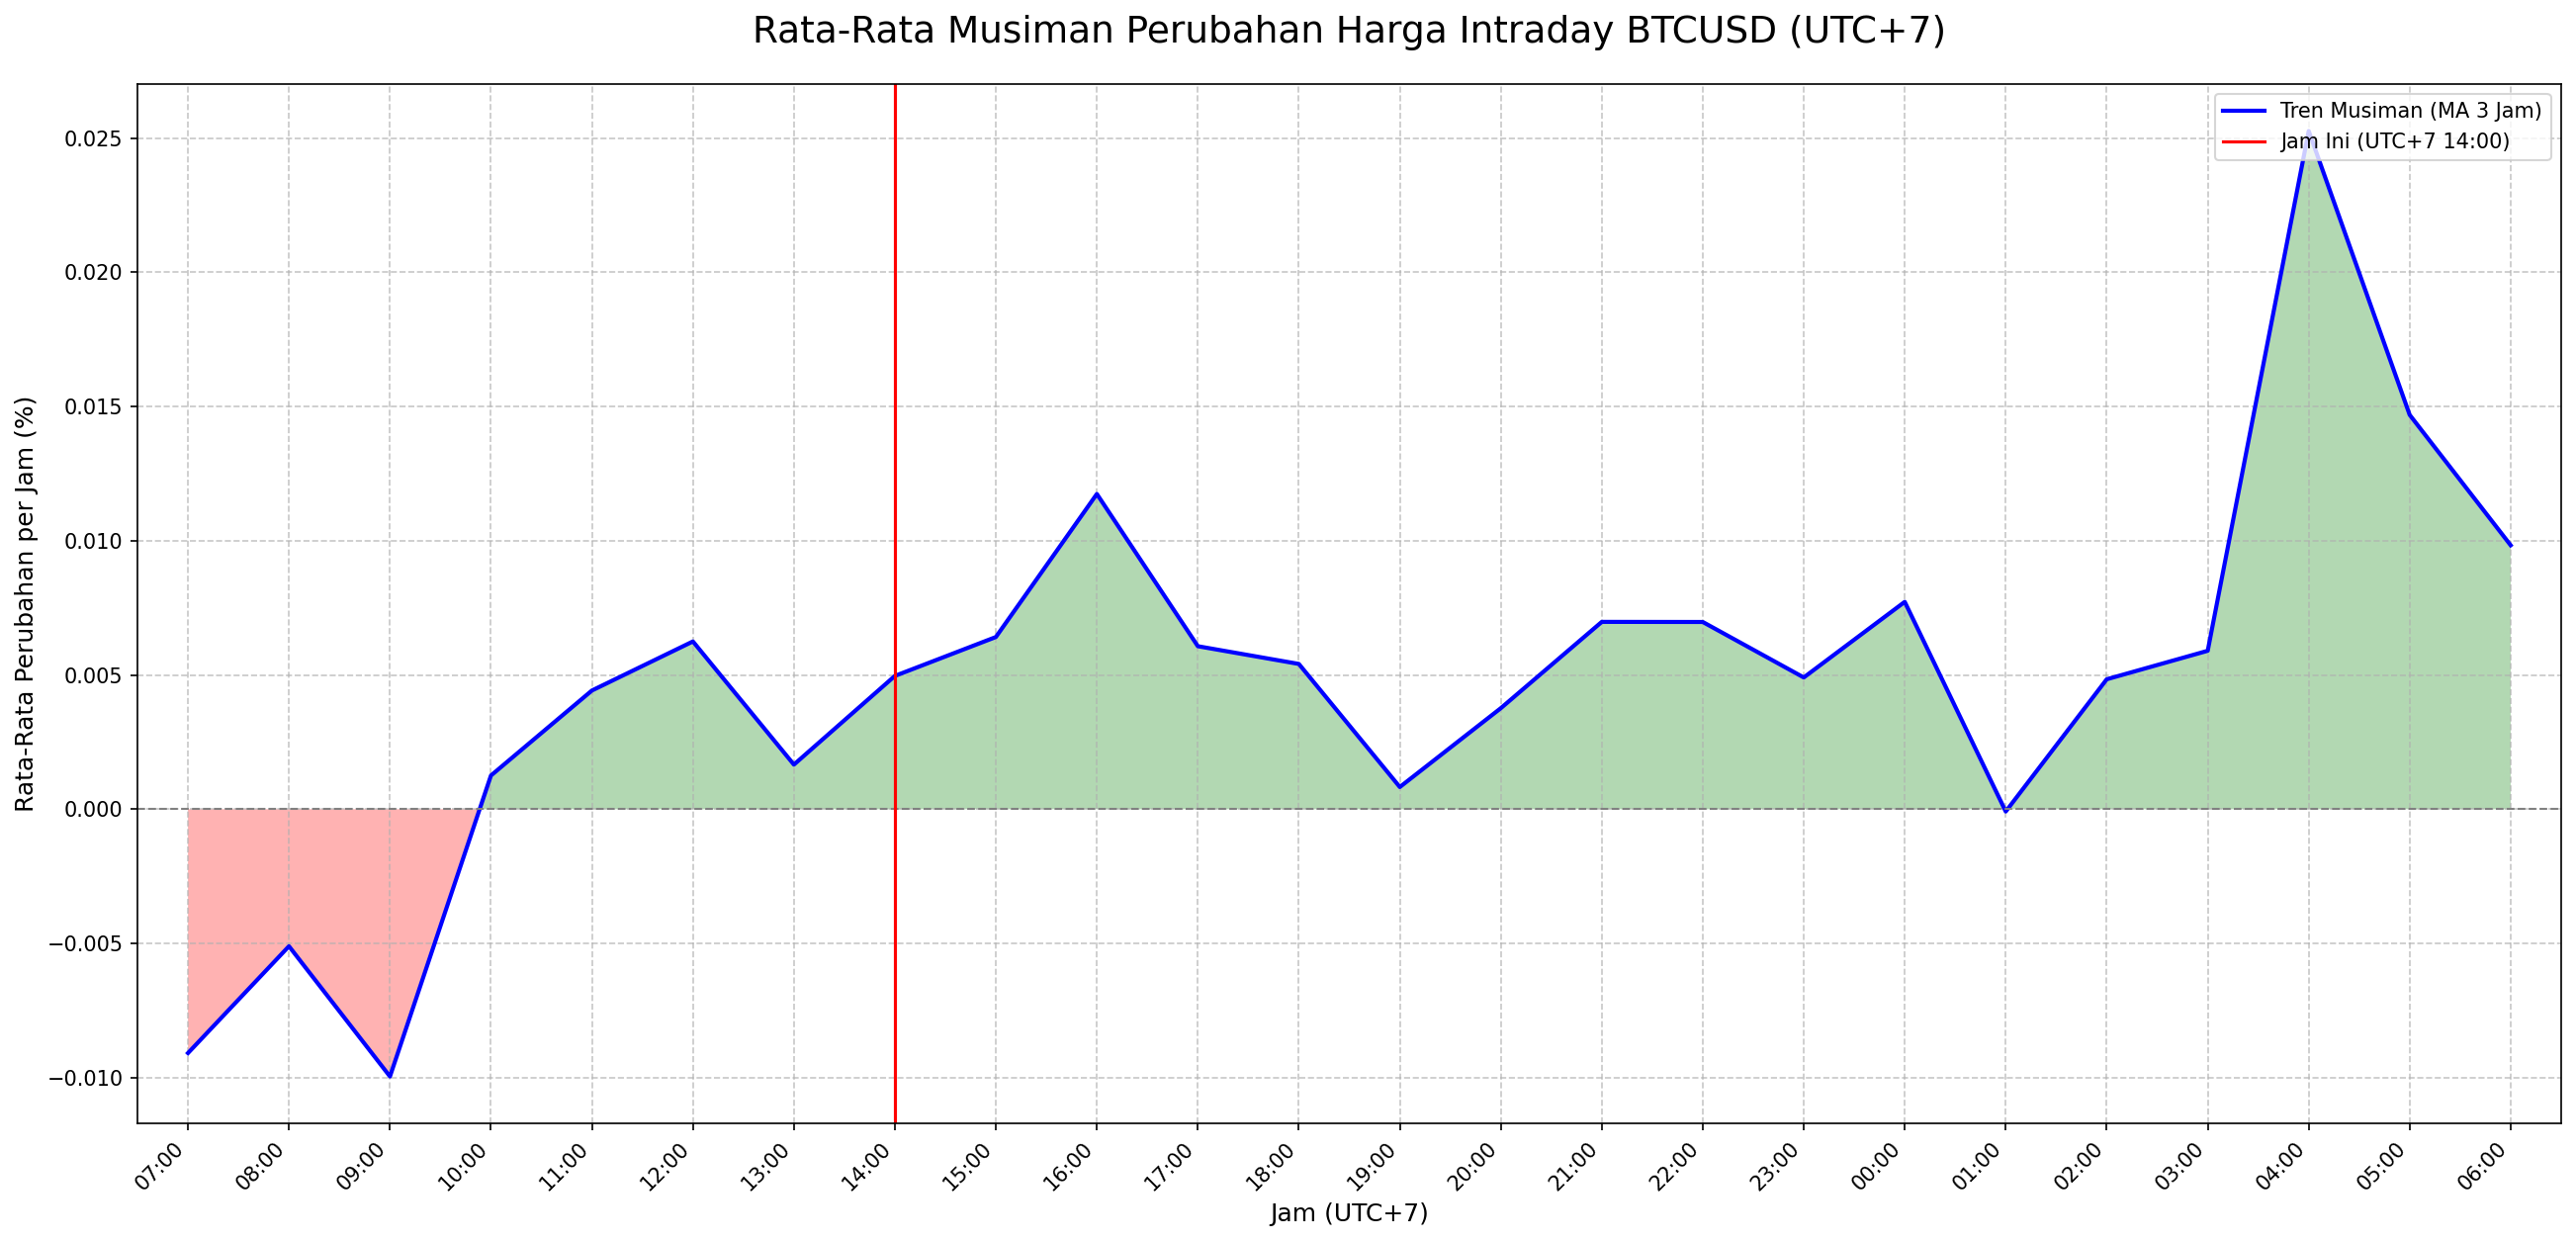


📊 Analisis Musiman Perubahan Harga Intraday untuk BTCUSD
📅 Tanggal & Waktu Analisis: 22 June 2025, 07:29:43 UTC

Ringkasan Tren untuk Jam Ini (UTC+7 14:00)
  Tren Rata-rata pada jam ini: 0.0050%
  Bias Historis: BULLISH

Jam Puncak Tekanan Beli & Jual (Berdasarkan Tren Historis)
  Tekanan BELI terkuat terjadi pada Jam: 04:00 UTC+7 (Rata-rata: +0.0253%)
  Tekanan JUAL terkuat terjadi pada Jam: 09:00 UTC+7 (Rata-rata: -0.0100%)


Ringkasan juga telah disimpan ke file: Seasonal_Intraday_Change_Distribution/2025-06-22_07-29-43-BTCUSD_H1_202107022100_202506192100 - intraday_change_summary.txt


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
from zoneinfo import ZoneInfo

# --- 1. Pengaturan Awal (Folder & Nama File) ---
# Mengatur zona waktu ke UTC untuk analisis intraday
zona_waktu_utc = ZoneInfo("UTC")

# PENTING: Pastikan file ini ada dan berisi data per jam
# dengan kolom <DATE>, <TIME>, <OPEN>, <HIGH>, <LOW>, <CLOSE>
input_csv_filename = "BTCUSD_H1_202107022100_202506192100.csv"

# Mendapatkan waktu UTC saat ini untuk ringkasan dan nama file dinamis
now_utc = datetime.now(zona_waktu_utc)
now_utc_str = now_utc.strftime('%Y-%m-%d_%H-%M-%S')
output_folder = "Seasonal_Intraday_Change_Distribution" # Folder output

# Membuat folder output jika belum ada
os.makedirs(output_folder, exist_ok=True)

# Nama file output untuk ringkasan teks
summary_txt_filename = f"{now_utc_str}-{input_csv_filename.replace('.csv','')} - intraday_change_summary.txt"
summary_txt_filepath = os.path.join(output_folder, summary_txt_filename)

# --- 2. Muat & Siapkan Data ---
try:
    # Mengasumsikan data dipisahkan oleh spasi dengan kolom DATE dan TIME
    df = pd.read_csv(input_csv_filename, delim_whitespace=True)
except FileNotFoundError:
    print(f"Error: Pastikan file '{input_csv_filename}' berada di direktori yang sama.")
    exit()

# Membersihkan nama kolom (menghapus simbol '<>')
df.columns = [c.strip('<>') for c in df.columns]

# Menggabungkan kolom DATE dan TIME menjadi satu objek datetime
df['DATETIME_UTC'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'], format='%Y.%m.%d %H:%M', utc=True)
df.set_index('DATETIME_UTC', inplace=True)
df.dropna(inplace=True)

# Ekstrak jam dalam sehari (0-23 UTC)
df['hour_of_day_utc'] = df.index.hour

# --- 3. Hitung Perubahan Harga Rata-rata per Jam ---
# Hitung perubahan persentase untuk setiap candle: (Close - Open) / Open
df['pct_change'] = ((df['CLOSE'] - df['OPEN']) / df['OPEN']) * 100

# Kelompokkan berdasarkan jam dan hitung rata-rata perubahan persentase
avg_hourly_change = df.groupby('hour_of_day_utc')['pct_change'].mean()

# --- 4. Hitung Tren Musiman (Moving Average) ---
# Gunakan window 3 jam untuk tren intraday. Concat untuk menangani wrap-around (jam 23 ke 0)
extended_avg = pd.concat([avg_hourly_change[-2:], avg_hourly_change, avg_hourly_change[:2]])
seasonal_trend = extended_avg.rolling(window=3, center=True).mean().iloc[2:-2]


# --- 5. Persiapan untuk Plot ---
# Dapatkan jam saat ini (UTC) untuk penandaan pada plot
current_hour_utc = now_utc.hour
current_hour_utc7 = (current_hour_utc + 7) % 24 # Hitung jam saat ini dalam UTC+7

# Atur tick dan label sumbu x untuk jam (0-23 UTC dikonversi ke UTC+7 untuk label)
tick_locations = np.arange(0, 24)
tick_labels = [f'{(h + 7) % 24:02d}:00' for h in tick_locations]

# Ekstrak nama aset dari nama file untuk judul dinamis
asset_name = input_csv_filename.split('_')[0]

# --- 6. Buat dan Tampilkan Plot Seasonality ---
fig, ax = plt.subplots(figsize=(18, 9), dpi=150)

# Plot garis tren musiman
ax.plot(seasonal_trend.index, seasonal_trend.values, color='blue', linewidth=2, label=f'Tren Musiman (MA 3 Jam)')

# Buat area shading hijau (positif) dan merah (negatif) berdasarkan tren
ax.fill_between(seasonal_trend.index, seasonal_trend.values, 0,
                where=seasonal_trend.values >= 0, facecolor='green', interpolate=True, alpha=0.3)
ax.fill_between(seasonal_trend.index, seasonal_trend.values, 0,
                where=seasonal_trend.values < 0, facecolor='red', interpolate=True, alpha=0.3)

# Tambahkan garis horizontal di y=0
ax.axhline(0, color='grey', linestyle='--', linewidth=1)

# Tambahkan garis vertikal untuk menandai jam saat ini
ax.axvline(x=current_hour_utc, color='red', linestyle='-', linewidth=1.5, label=f'Jam Ini (UTC+7 {current_hour_utc7:02d}:00)')


# Pengaturan Judul dan Label
ax.set_title(f'Rata-Rata Musiman Perubahan Harga Intraday {asset_name} (UTC+7)', pad=20, fontsize=18)
ax.set_xlabel('Jam (UTC+7)', fontsize=12)
ax.set_ylabel('Rata-Rata Perubahan per Jam (%)', fontsize=12)
ax.grid(axis='both', linestyle='--', alpha=0.7)

# Atur label sumbu-x
ax.set_xticks(ticks=tick_locations)
ax.set_xticklabels(tick_labels, rotation=45, ha='right')
ax.set_xlim(-0.5, 23.5)

# Atur legenda
ax.legend(loc='upper right', fontsize=10)

fig.tight_layout(pad=3.0)
print("Menampilkan grafik Rata-Rata Musiman Perubahan Harga Intraday...")
plt.show()

# --- 7. Buat Teks Ringkasan ---
# Cari jam dengan bias beli dan jual terkuat
max_buy_hour = seasonal_trend.idxmax()
max_buy_value = seasonal_trend.max()
max_sell_hour = seasonal_trend.idxmin()
max_sell_value = seasonal_trend.min()

summary_lines = []
summary_lines.append(f"📊 Analisis Musiman Perubahan Harga Intraday untuk {asset_name}")
summary_lines.append(f"📅 Tanggal & Waktu Analisis: {now_utc.strftime('%d %B %Y, %H:%M:%S UTC')}")
summary_lines.append("\n" + "="*60)
summary_lines.append(f"Ringkasan Tren untuk Jam Ini (UTC+7 {current_hour_utc7:02d}:00)")
summary_lines.append("="*60)

# Ringkasan untuk jam saat ini
if current_hour_utc in seasonal_trend.index:
    current_trend_val = seasonal_trend.loc[current_hour_utc]
    bias = "BULLISH" if current_trend_val > 0 else "BEARISH"
    summary_lines.append(f"  Tren Rata-rata pada jam ini: {current_trend_val:.4f}%")
    summary_lines.append(f"  Bias Historis: {bias}")
else:
    summary_lines.append("  Data tren tidak tersedia untuk jam ini.")

summary_lines.append("\n" + "="*60)
summary_lines.append("Jam Puncak Tekanan Beli & Jual (Berdasarkan Tren Historis)")
summary_lines.append("="*60)
summary_lines.append(f"  Tekanan BELI terkuat terjadi pada Jam: {(max_buy_hour + 7) % 24:02d}:00 UTC+7 (Rata-rata: +{max_buy_value:.4f}%)")
summary_lines.append(f"  Tekanan JUAL terkuat terjadi pada Jam: {(max_sell_hour + 7) % 24:02d}:00 UTC+7 (Rata-rata: {max_sell_value:.4f}%)")
summary_lines.append("\n" + "="*60)

summary_text = "\n".join(summary_lines)

# Tampilkan ringkasan di konsol
print("\n" + summary_text)

# (Opsional) Simpan ringkasan ke file teks
with open(summary_txt_filepath, 'w', encoding='utf-8') as f:
    f.write(summary_text)
print(f"\nRingkasan juga telah disimpan ke file: {summary_txt_filepath}")


Menampilkan grafik Rata-Rata Musiman Perubahan Harga Intraday (terpisah)...


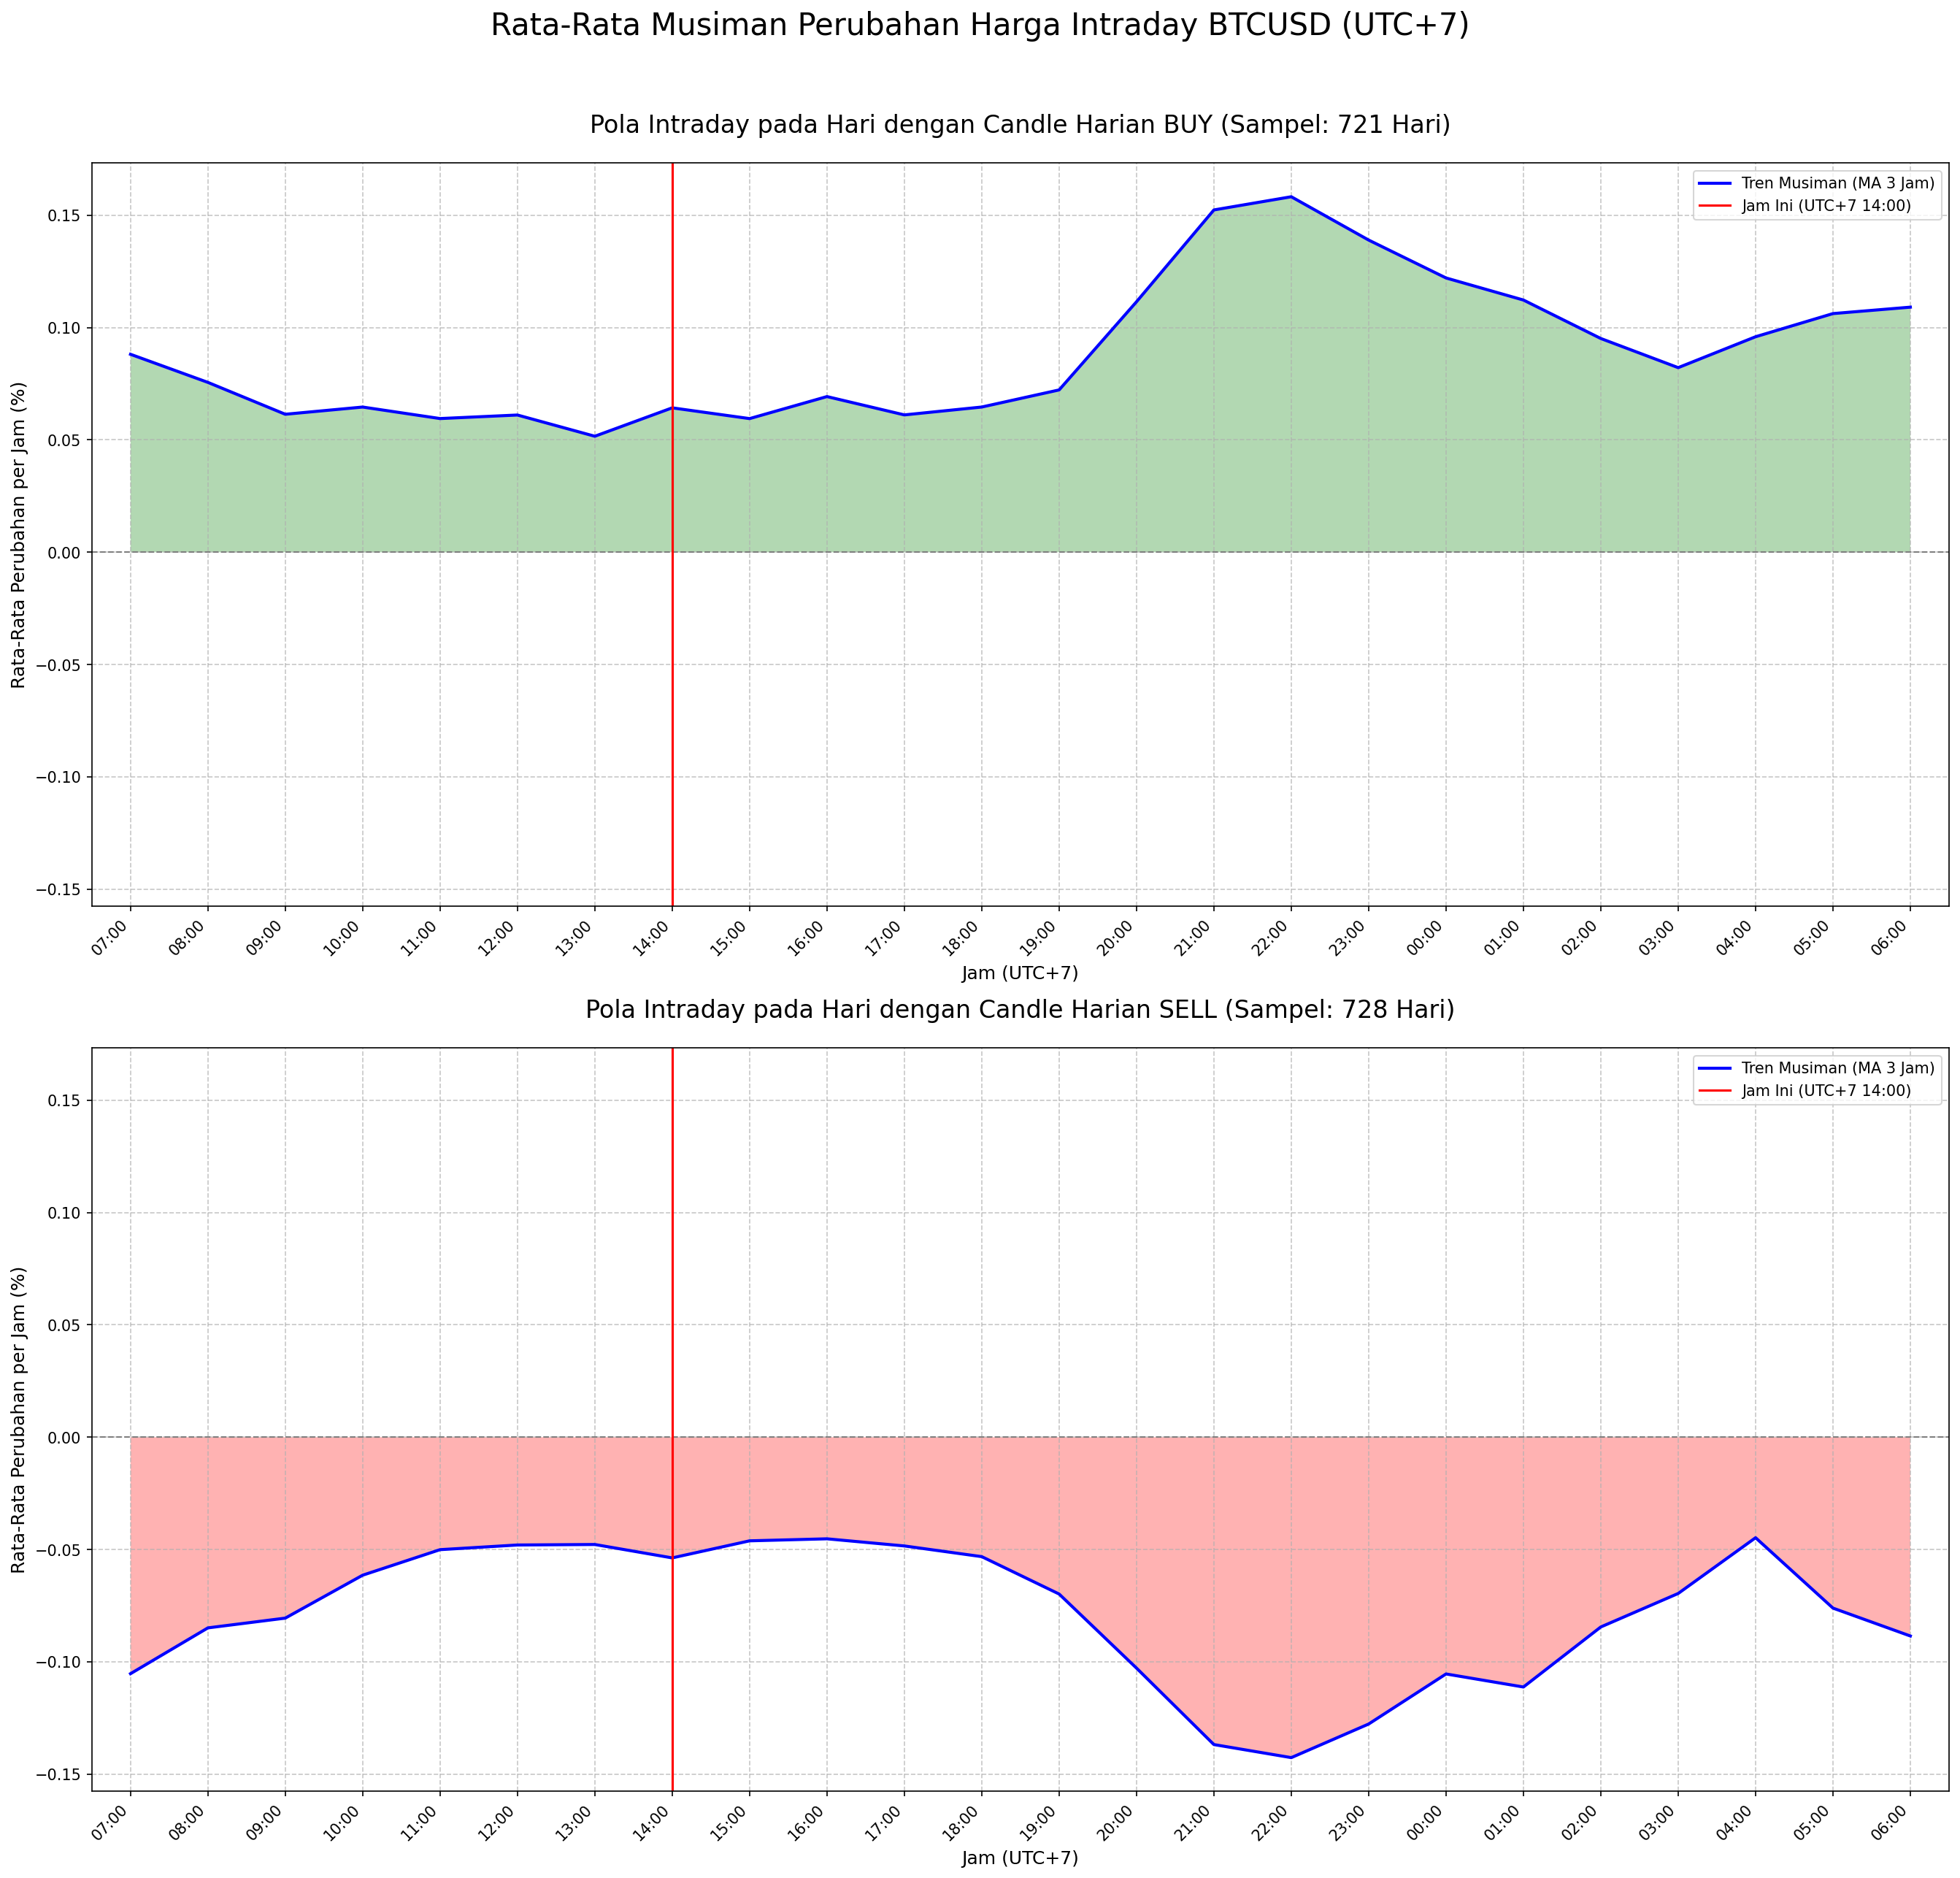


📊 Analisis Musiman Perubahan Harga Intraday untuk BTCUSD
📅 Tanggal & Waktu Analisis: 22 June 2025, 07:40:22 UTC

Jam Puncak Tekanan Beli & Jual (Berdasarkan Tren Historis)

--- Kondisi: Candle Harian BUY (Sampel: 721 Hari) ---
  Tekanan BELI terkuat terjadi pada Jam: 22:00 UTC+7 (Rata-rata: +0.1583%)
  Tekanan JUAL terkuat terjadi pada Jam: 13:00 UTC+7 (Rata-rata: 0.0516%)

--- Kondisi: Candle Harian SELL (Sampel: 728 Hari) ---
  Tekanan BELI terkuat terjadi pada Jam: 04:00 UTC+7 (Rata-rata: +-0.0448%)
  Tekanan JUAL terkuat terjadi pada Jam: 22:00 UTC+7 (Rata-rata: -0.1427%)



In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
from zoneinfo import ZoneInfo

# --- Fungsi Bantuan ---
def analyze_and_plot(data, ax, title, current_hour_utc, current_hour_utc7, tick_locations, tick_labels):
    """
    Fungsi untuk menganalisis data per jam dan membuat plot seasonality.
    """
    # Hitung jumlah sampel hari unik
    num_days = data.index.normalize().nunique()
    title_with_samples = f"{title} (Sampel: {num_days} Hari)"

    if data.empty or data['pct_change'].isnull().all():
        ax.text(0.5, 0.5, 'Tidak ada data yang cukup untuk kondisi ini', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.set_title(title_with_samples, pad=20, fontsize=16)
        ax.set_xticks(ticks=tick_locations)
        ax.set_xticklabels(tick_labels, rotation=45, ha='right')
        ax.set_xlim(-0.5, 23.5)
        return None

    # 1. Hitung Perubahan Harga Rata-rata per Jam
    avg_hourly_change = data.groupby('hour_of_day_utc')['pct_change'].mean().reindex(range(24)).fillna(0)

    # 2. Hitung Tren Musiman (Moving Average)
    extended_avg = pd.concat([avg_hourly_change[-2:], avg_hourly_change, avg_hourly_change[:2]])
    seasonal_trend = extended_avg.rolling(window=3, center=True).mean().iloc[2:-2]

    # 3. Plotting
    ax.plot(seasonal_trend.index, seasonal_trend.values, color='blue', linewidth=2, label='Tren Musiman (MA 3 Jam)')
    ax.fill_between(seasonal_trend.index, seasonal_trend.values, 0, where=seasonal_trend.values >= 0, facecolor='green', interpolate=True, alpha=0.3)
    ax.fill_between(seasonal_trend.index, seasonal_trend.values, 0, where=seasonal_trend.values < 0, facecolor='red', interpolate=True, alpha=0.3)
    ax.axhline(0, color='grey', linestyle='--', linewidth=1)
    ax.axvline(x=current_hour_utc, color='red', linestyle='-', linewidth=1.5, label=f'Jam Ini (UTC+7 {current_hour_utc7:02d}:00)')
    ax.set_title(title_with_samples, pad=20, fontsize=16)
    ax.set_xlabel('Jam (UTC+7)', fontsize=12)
    ax.set_ylabel('Rata-Rata Perubahan per Jam (%)', fontsize=12)
    ax.grid(axis='both', linestyle='--', alpha=0.7)
    ax.set_xticks(ticks=tick_locations)
    ax.set_xticklabels(tick_labels, rotation=45, ha='right')
    ax.set_xlim(-0.5, 23.5)
    ax.legend(loc='upper right', fontsize=10)
    
    return seasonal_trend

def generate_summary(trend_data, original_data, condition_name):
    """
    Fungsi untuk membuat ringkasan teks dari data tren.
    """
    num_days = original_data.index.normalize().nunique()
    
    if trend_data is None or trend_data.empty:
        return [f"\n--- {condition_name} (Sampel: {num_days} Hari) ---", "Tidak ada data yang cukup untuk dianalisis."]

    max_buy_hour = trend_data.idxmax()
    max_buy_value = trend_data.max()
    max_sell_hour = trend_data.idxmin()
    max_sell_value = trend_data.min()

    summary = [
        f"\n--- {condition_name} (Sampel: {num_days} Hari) ---",
        f"  Tekanan BELI terkuat terjadi pada Jam: {(max_buy_hour + 7) % 24:02d}:00 UTC+7 (Rata-rata: +{max_buy_value:.4f}%)",
        f"  Tekanan JUAL terkuat terjadi pada Jam: {(max_sell_hour + 7) % 24:02d}:00 UTC+7 (Rata-rata: {max_sell_value:.4f}%)"
    ]
    return summary

# --- 1. Pengaturan Awal (Folder & Nama File) ---
zona_waktu_utc = ZoneInfo("UTC")
input_csv_filename = "BTCUSD_H1_202107022100_202506192100.csv"
now_utc = datetime.now(zona_waktu_utc)
now_utc_str = now_utc.strftime('%Y-%m-%d_%H-%M-%S')
output_folder = "Seasonal_Intraday_Change_Distribution"
os.makedirs(output_folder, exist_ok=True)
# summary_txt_filepath = os.path.join(output_folder, f"{now_utc_str}-{input_csv_filename.replace('.csv','')} - intraday_change_summary.txt") # Dihapus

# --- 2. Muat & Siapkan Data ---
try:
    df = pd.read_csv(input_csv_filename, delim_whitespace=True)
except FileNotFoundError:
    print(f"Error: Pastikan file '{input_csv_filename}' berada di direktori yang sama.")
    exit()

df.columns = [c.strip('<>') for c in df.columns]
df['DATETIME_UTC'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'], format='%Y.%m.%d %H:%M', utc=True)
df.set_index('DATETIME_UTC', inplace=True)
df.dropna(inplace=True)
df['hour_of_day_utc'] = df.index.hour
df['pct_change'] = ((df['CLOSE'] - df['OPEN']) / df['OPEN']) * 100
asset_name = input_csv_filename.split('_')[0]

# --- 3. Tentukan Arah Candle Harian & Pisahkan Data ---
daily_df = df['CLOSE'].resample('D').last().to_frame()
daily_df['OPEN'] = df['OPEN'].resample('D').first()
daily_df.dropna(inplace=True)
daily_df['daily_direction'] = np.sign(daily_df['CLOSE'] - daily_df['OPEN'])
df['daily_direction'] = df.index.normalize().map(daily_df['daily_direction'])

df_buy_days = df[df['daily_direction'] == 1].copy()
df_sell_days = df[df['daily_direction'] == -1].copy()

# --- 4. Persiapan untuk Plot ---
current_hour_utc = now_utc.hour
current_hour_utc7 = (current_hour_utc + 7) % 24
tick_locations = np.arange(0, 24)
tick_labels = [f'{(h + 7) % 24:02d}:00' for h in tick_locations]

# --- 5. Buat dan Tampilkan Plot Seasonality ---
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 18), dpi=150, sharey=True)
fig.suptitle(f'Rata-Rata Musiman Perubahan Harga Intraday {asset_name} (UTC+7)', fontsize=20)

# Plot untuk Buy Days
trend_buy = analyze_and_plot(df_buy_days, axes[0], 'Pola Intraday pada Hari dengan Candle Harian BUY', current_hour_utc, current_hour_utc7, tick_locations, tick_labels)
# Plot untuk Sell Days
trend_sell = analyze_and_plot(df_sell_days, axes[1], 'Pola Intraday pada Hari dengan Candle Harian SELL', current_hour_utc, current_hour_utc7, tick_locations, tick_labels)

fig.tight_layout(rect=[0, 0.03, 1, 0.96])
print("Menampilkan grafik Rata-Rata Musiman Perubahan Harga Intraday (terpisah)...")
plt.show()

# --- 6. Buat Teks Ringkasan ---
summary_lines = []
summary_lines.append(f"📊 Analisis Musiman Perubahan Harga Intraday untuk {asset_name}")
summary_lines.append(f"📅 Tanggal & Waktu Analisis: {now_utc.strftime('%d %B %Y, %H:%M:%S UTC')}")
summary_lines.append("\n" + "="*60)
summary_lines.append("Jam Puncak Tekanan Beli & Jual (Berdasarkan Tren Historis)")
summary_lines.append("="*60)

summary_buy = generate_summary(trend_buy, df_buy_days, "Kondisi: Candle Harian BUY")
summary_lines.extend(summary_buy)

summary_sell = generate_summary(trend_sell, df_sell_days, "Kondisi: Candle Harian SELL")
summary_lines.extend(summary_sell)

summary_lines.append("\n" + "="*60)
summary_text = "\n".join(summary_lines)

print("\n" + summary_text)

# with open(summary_txt_filepath, 'w', encoding='utf-8') as f:
#     f.write(summary_text)
# print(f"\nRingkasan juga telah disimpan ke file: {summary_txt_filepath}")


Menampilkan grafik Rata-Rata Musiman Perubahan Harga Intraday (terpisah)...


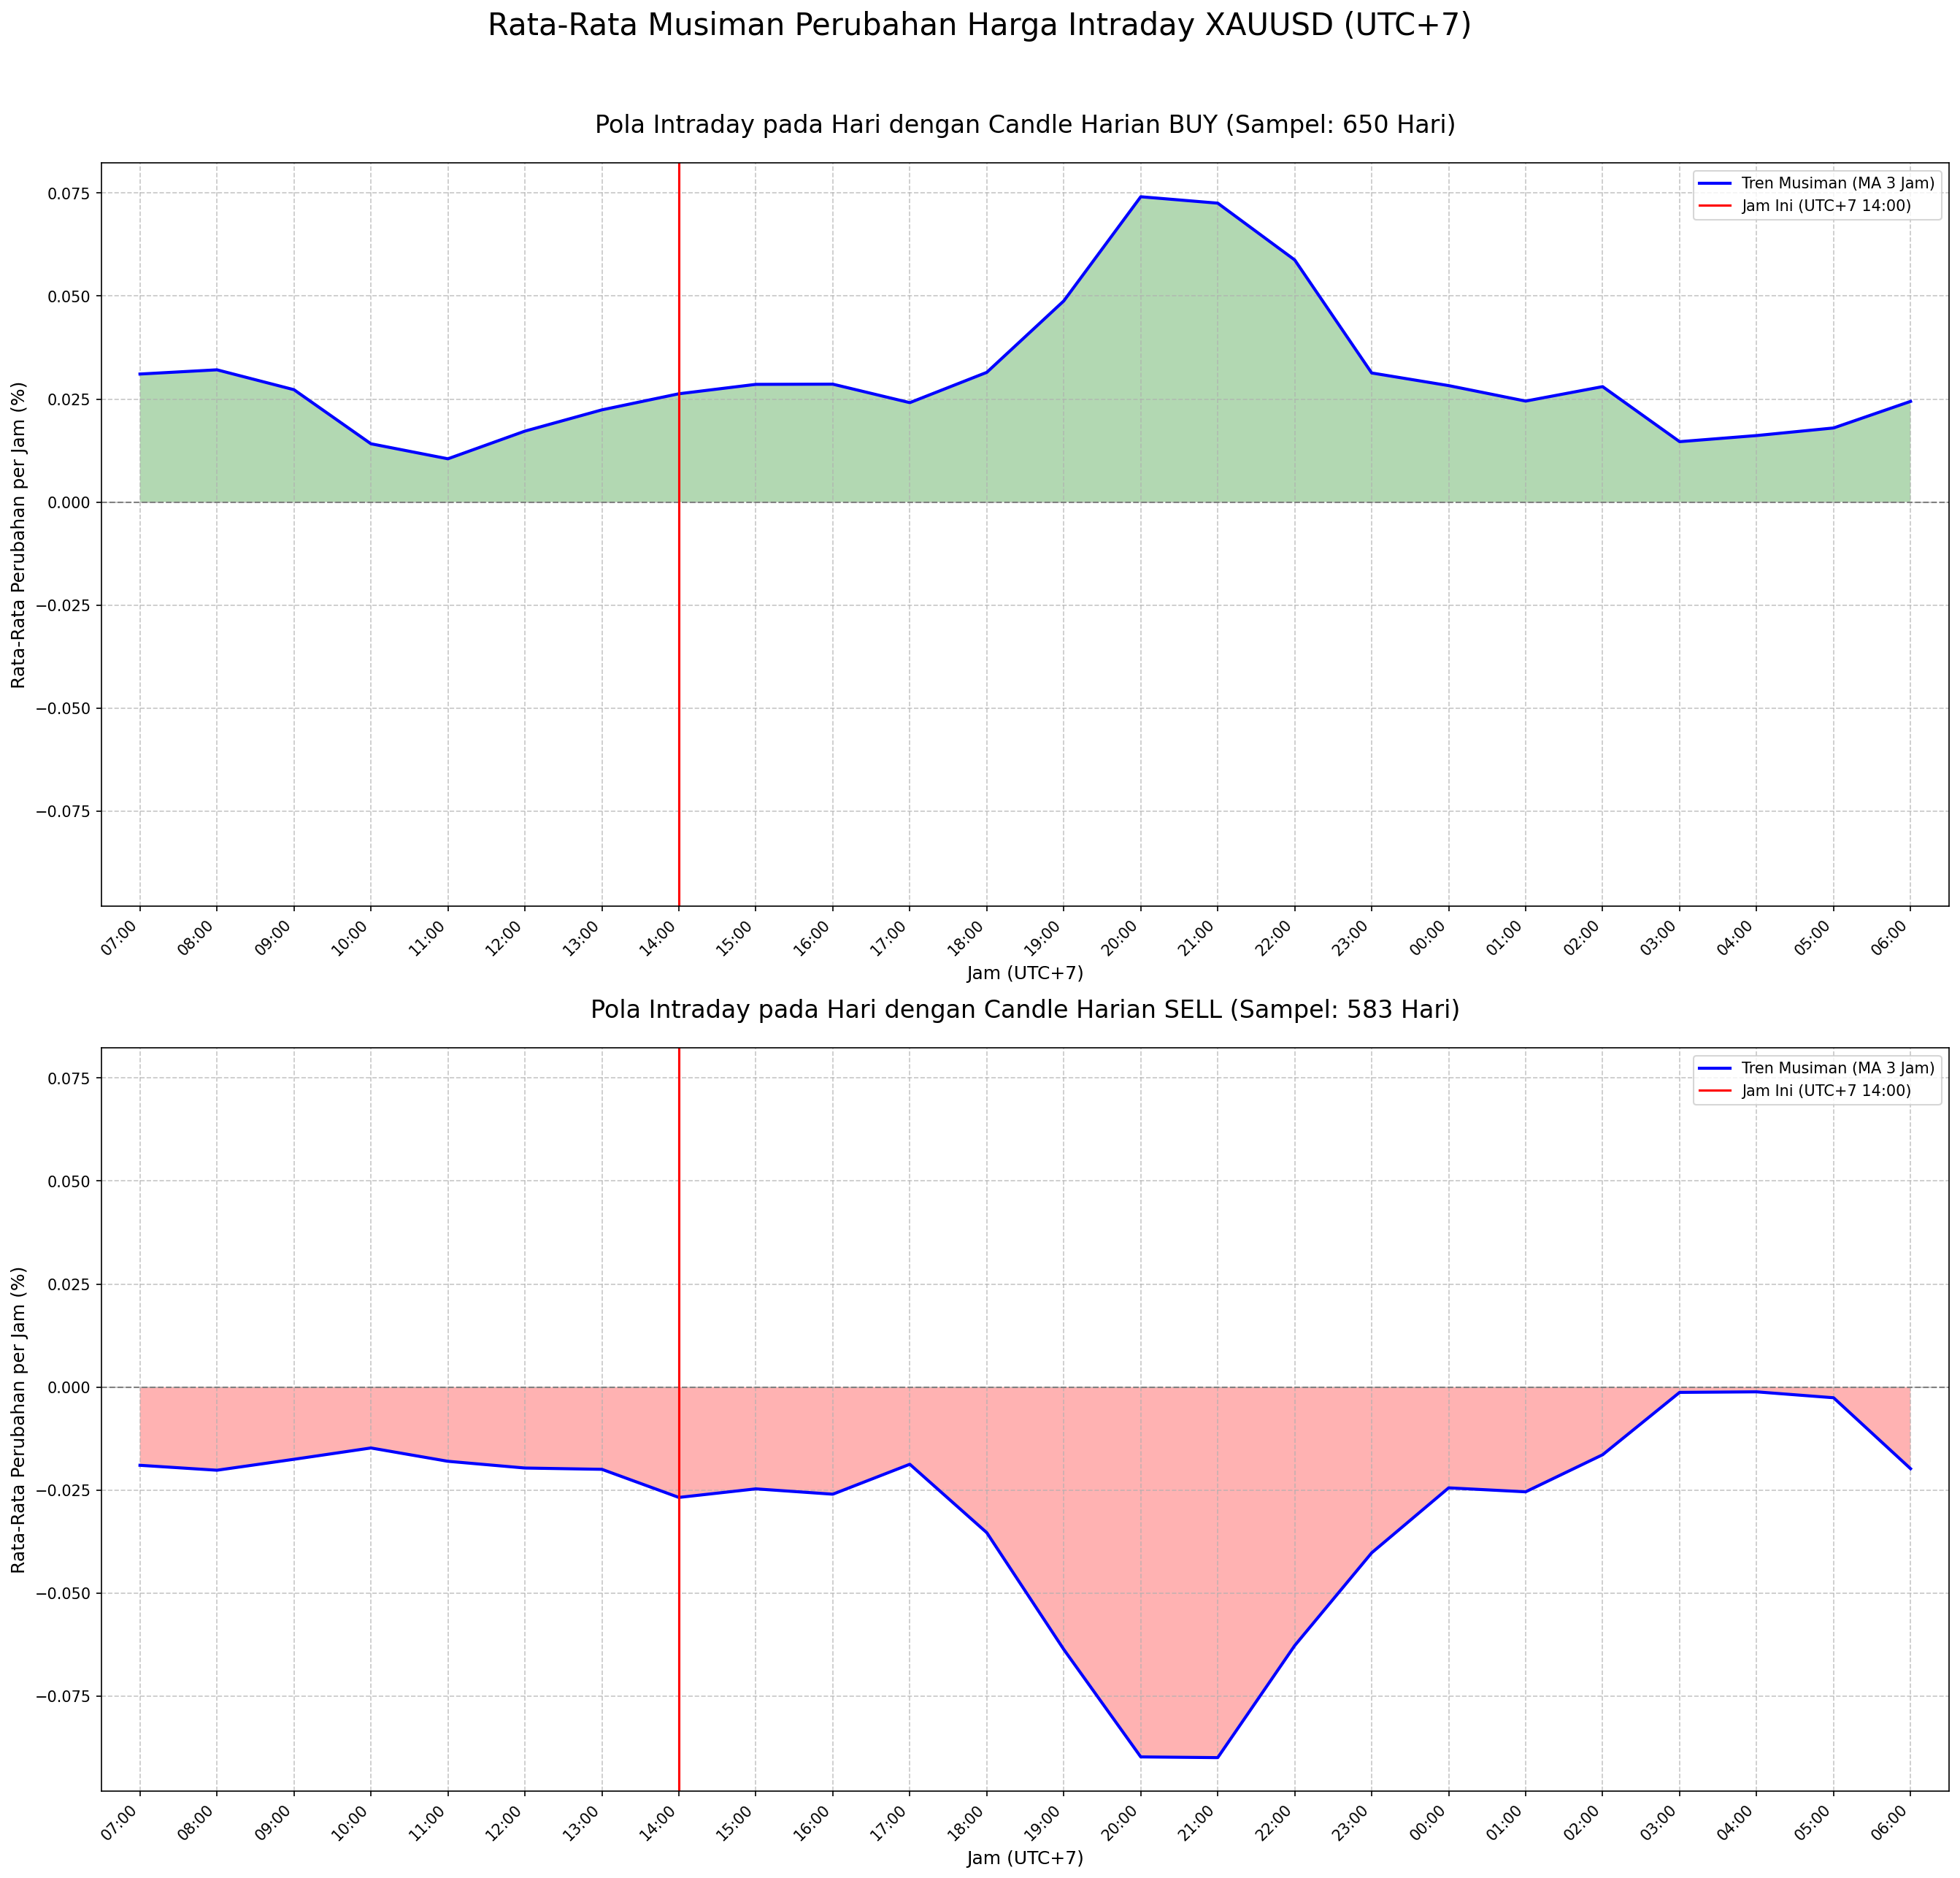


📊 Analisis Musiman Perubahan Harga Intraday untuk XAUUSD
📅 Tanggal & Waktu Analisis: 22 June 2025, 07:42:43 UTC

Jam Puncak Tekanan Beli & Jual (Berdasarkan Tren Historis)

--- Kondisi: Candle Harian BUY (Sampel: 650 Hari) ---
  Tekanan BELI terkuat terjadi pada Jam: 20:00 UTC+7 (Rata-rata: +0.0741%)
  Tekanan JUAL terkuat terjadi pada Jam: 11:00 UTC+7 (Rata-rata: 0.0105%)

--- Kondisi: Candle Harian SELL (Sampel: 583 Hari) ---
  Tekanan BELI terkuat terjadi pada Jam: 04:00 UTC+7 (Rata-rata: +-0.0012%)
  Tekanan JUAL terkuat terjadi pada Jam: 21:00 UTC+7 (Rata-rata: -0.0899%)



In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
from zoneinfo import ZoneInfo

# --- Fungsi Bantuan ---
def analyze_and_plot(data, ax, title, current_hour_utc, current_hour_utc7, tick_locations, tick_labels):
    """
    Fungsi untuk menganalisis data per jam dan membuat plot seasonality.
    """
    # Hitung jumlah sampel hari unik
    num_days = data.index.normalize().nunique()
    title_with_samples = f"{title} (Sampel: {num_days} Hari)"

    if data.empty or data['pct_change'].isnull().all():
        ax.text(0.5, 0.5, 'Tidak ada data yang cukup untuk kondisi ini', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.set_title(title_with_samples, pad=20, fontsize=16)
        ax.set_xticks(ticks=tick_locations)
        ax.set_xticklabels(tick_labels, rotation=45, ha='right')
        ax.set_xlim(-0.5, 23.5)
        return None

    # 1. Hitung Perubahan Harga Rata-rata per Jam
    avg_hourly_change = data.groupby('hour_of_day_utc')['pct_change'].mean().reindex(range(24)).fillna(0)

    # 2. Hitung Tren Musiman (Moving Average)
    extended_avg = pd.concat([avg_hourly_change[-2:], avg_hourly_change, avg_hourly_change[:2]])
    seasonal_trend = extended_avg.rolling(window=3, center=True).mean().iloc[2:-2]

    # 3. Plotting
    ax.plot(seasonal_trend.index, seasonal_trend.values, color='blue', linewidth=2, label='Tren Musiman (MA 3 Jam)')
    ax.fill_between(seasonal_trend.index, seasonal_trend.values, 0, where=seasonal_trend.values >= 0, facecolor='green', interpolate=True, alpha=0.3)
    ax.fill_between(seasonal_trend.index, seasonal_trend.values, 0, where=seasonal_trend.values < 0, facecolor='red', interpolate=True, alpha=0.3)
    ax.axhline(0, color='grey', linestyle='--', linewidth=1)
    ax.axvline(x=current_hour_utc, color='red', linestyle='-', linewidth=1.5, label=f'Jam Ini (UTC+7 {current_hour_utc7:02d}:00)')
    ax.set_title(title_with_samples, pad=20, fontsize=16)
    ax.set_xlabel('Jam (UTC+7)', fontsize=12)
    ax.set_ylabel('Rata-Rata Perubahan per Jam (%)', fontsize=12)
    ax.grid(axis='both', linestyle='--', alpha=0.7)
    ax.set_xticks(ticks=tick_locations)
    ax.set_xticklabels(tick_labels, rotation=45, ha='right')
    ax.set_xlim(-0.5, 23.5)
    ax.legend(loc='upper right', fontsize=10)
    
    return seasonal_trend

def generate_summary(trend_data, original_data, condition_name):
    """
    Fungsi untuk membuat ringkasan teks dari data tren.
    """
    num_days = original_data.index.normalize().nunique()
    
    if trend_data is None or trend_data.empty:
        return [f"\n--- {condition_name} (Sampel: {num_days} Hari) ---", "Tidak ada data yang cukup untuk dianalisis."]

    max_buy_hour = trend_data.idxmax()
    max_buy_value = trend_data.max()
    max_sell_hour = trend_data.idxmin()
    max_sell_value = trend_data.min()

    summary = [
        f"\n--- {condition_name} (Sampel: {num_days} Hari) ---",
        f"  Tekanan BELI terkuat terjadi pada Jam: {(max_buy_hour + 7) % 24:02d}:00 UTC+7 (Rata-rata: +{max_buy_value:.4f}%)",
        f"  Tekanan JUAL terkuat terjadi pada Jam: {(max_sell_hour + 7) % 24:02d}:00 UTC+7 (Rata-rata: {max_sell_value:.4f}%)"
    ]
    return summary

# --- 1. Pengaturan Awal (Folder & Nama File) ---
zona_waktu_utc = ZoneInfo("UTC")
input_csv_filename = "XAUUSD_H1_202107042200_202506202000.csv"
now_utc = datetime.now(zona_waktu_utc)
now_utc_str = now_utc.strftime('%Y-%m-%d_%H-%M-%S')
output_folder = "Seasonal_Intraday_Change_Distribution"
os.makedirs(output_folder, exist_ok=True)
# summary_txt_filepath = os.path.join(output_folder, f"{now_utc_str}-{input_csv_filename.replace('.csv','')} - intraday_change_summary.txt") # Dihapus

# --- 2. Muat & Siapkan Data ---
try:
    df = pd.read_csv(input_csv_filename, delim_whitespace=True)
except FileNotFoundError:
    print(f"Error: Pastikan file '{input_csv_filename}' berada di direktori yang sama.")
    exit()

df.columns = [c.strip('<>') for c in df.columns]
df['DATETIME_UTC'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'], format='%Y.%m.%d %H:%M', utc=True)
df.set_index('DATETIME_UTC', inplace=True)
df.dropna(inplace=True)
df['hour_of_day_utc'] = df.index.hour
df['pct_change'] = ((df['CLOSE'] - df['OPEN']) / df['OPEN']) * 100
asset_name = input_csv_filename.split('_')[0]

# --- 3. Tentukan Arah Candle Harian & Pisahkan Data ---
daily_df = df['CLOSE'].resample('D').last().to_frame()
daily_df['OPEN'] = df['OPEN'].resample('D').first()
daily_df.dropna(inplace=True)
daily_df['daily_direction'] = np.sign(daily_df['CLOSE'] - daily_df['OPEN'])
df['daily_direction'] = df.index.normalize().map(daily_df['daily_direction'])

df_buy_days = df[df['daily_direction'] == 1].copy()
df_sell_days = df[df['daily_direction'] == -1].copy()

# --- 4. Persiapan untuk Plot ---
current_hour_utc = now_utc.hour
current_hour_utc7 = (current_hour_utc + 7) % 24
tick_locations = np.arange(0, 24)
tick_labels = [f'{(h + 7) % 24:02d}:00' for h in tick_locations]

# --- 5. Buat dan Tampilkan Plot Seasonality ---
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 18), dpi=150, sharey=True)
fig.suptitle(f'Rata-Rata Musiman Perubahan Harga Intraday {asset_name} (UTC+7)', fontsize=20)

# Plot untuk Buy Days
trend_buy = analyze_and_plot(df_buy_days, axes[0], 'Pola Intraday pada Hari dengan Candle Harian BUY', current_hour_utc, current_hour_utc7, tick_locations, tick_labels)
# Plot untuk Sell Days
trend_sell = analyze_and_plot(df_sell_days, axes[1], 'Pola Intraday pada Hari dengan Candle Harian SELL', current_hour_utc, current_hour_utc7, tick_locations, tick_labels)

fig.tight_layout(rect=[0, 0.03, 1, 0.96])
print("Menampilkan grafik Rata-Rata Musiman Perubahan Harga Intraday (terpisah)...")
plt.show()

# --- 6. Buat Teks Ringkasan ---
summary_lines = []
summary_lines.append(f"📊 Analisis Musiman Perubahan Harga Intraday untuk {asset_name}")
summary_lines.append(f"📅 Tanggal & Waktu Analisis: {now_utc.strftime('%d %B %Y, %H:%M:%S UTC')}")
summary_lines.append("\n" + "="*60)
summary_lines.append("Jam Puncak Tekanan Beli & Jual (Berdasarkan Tren Historis)")
summary_lines.append("="*60)

summary_buy = generate_summary(trend_buy, df_buy_days, "Kondisi: Candle Harian BUY")
summary_lines.extend(summary_buy)

summary_sell = generate_summary(trend_sell, df_sell_days, "Kondisi: Candle Harian SELL")
summary_lines.extend(summary_sell)

summary_lines.append("\n" + "="*60)
summary_text = "\n".join(summary_lines)

print("\n" + summary_text)

# with open(summary_txt_filepath, 'w', encoding='utf-8') as f:
#     f.write(summary_text)
# print(f"\nRingkasan juga telah disimpan ke file: {summary_txt_filepath}")


Menampilkan grafik Rata-Rata Musiman Perubahan Harga Intraday (terpisah)...


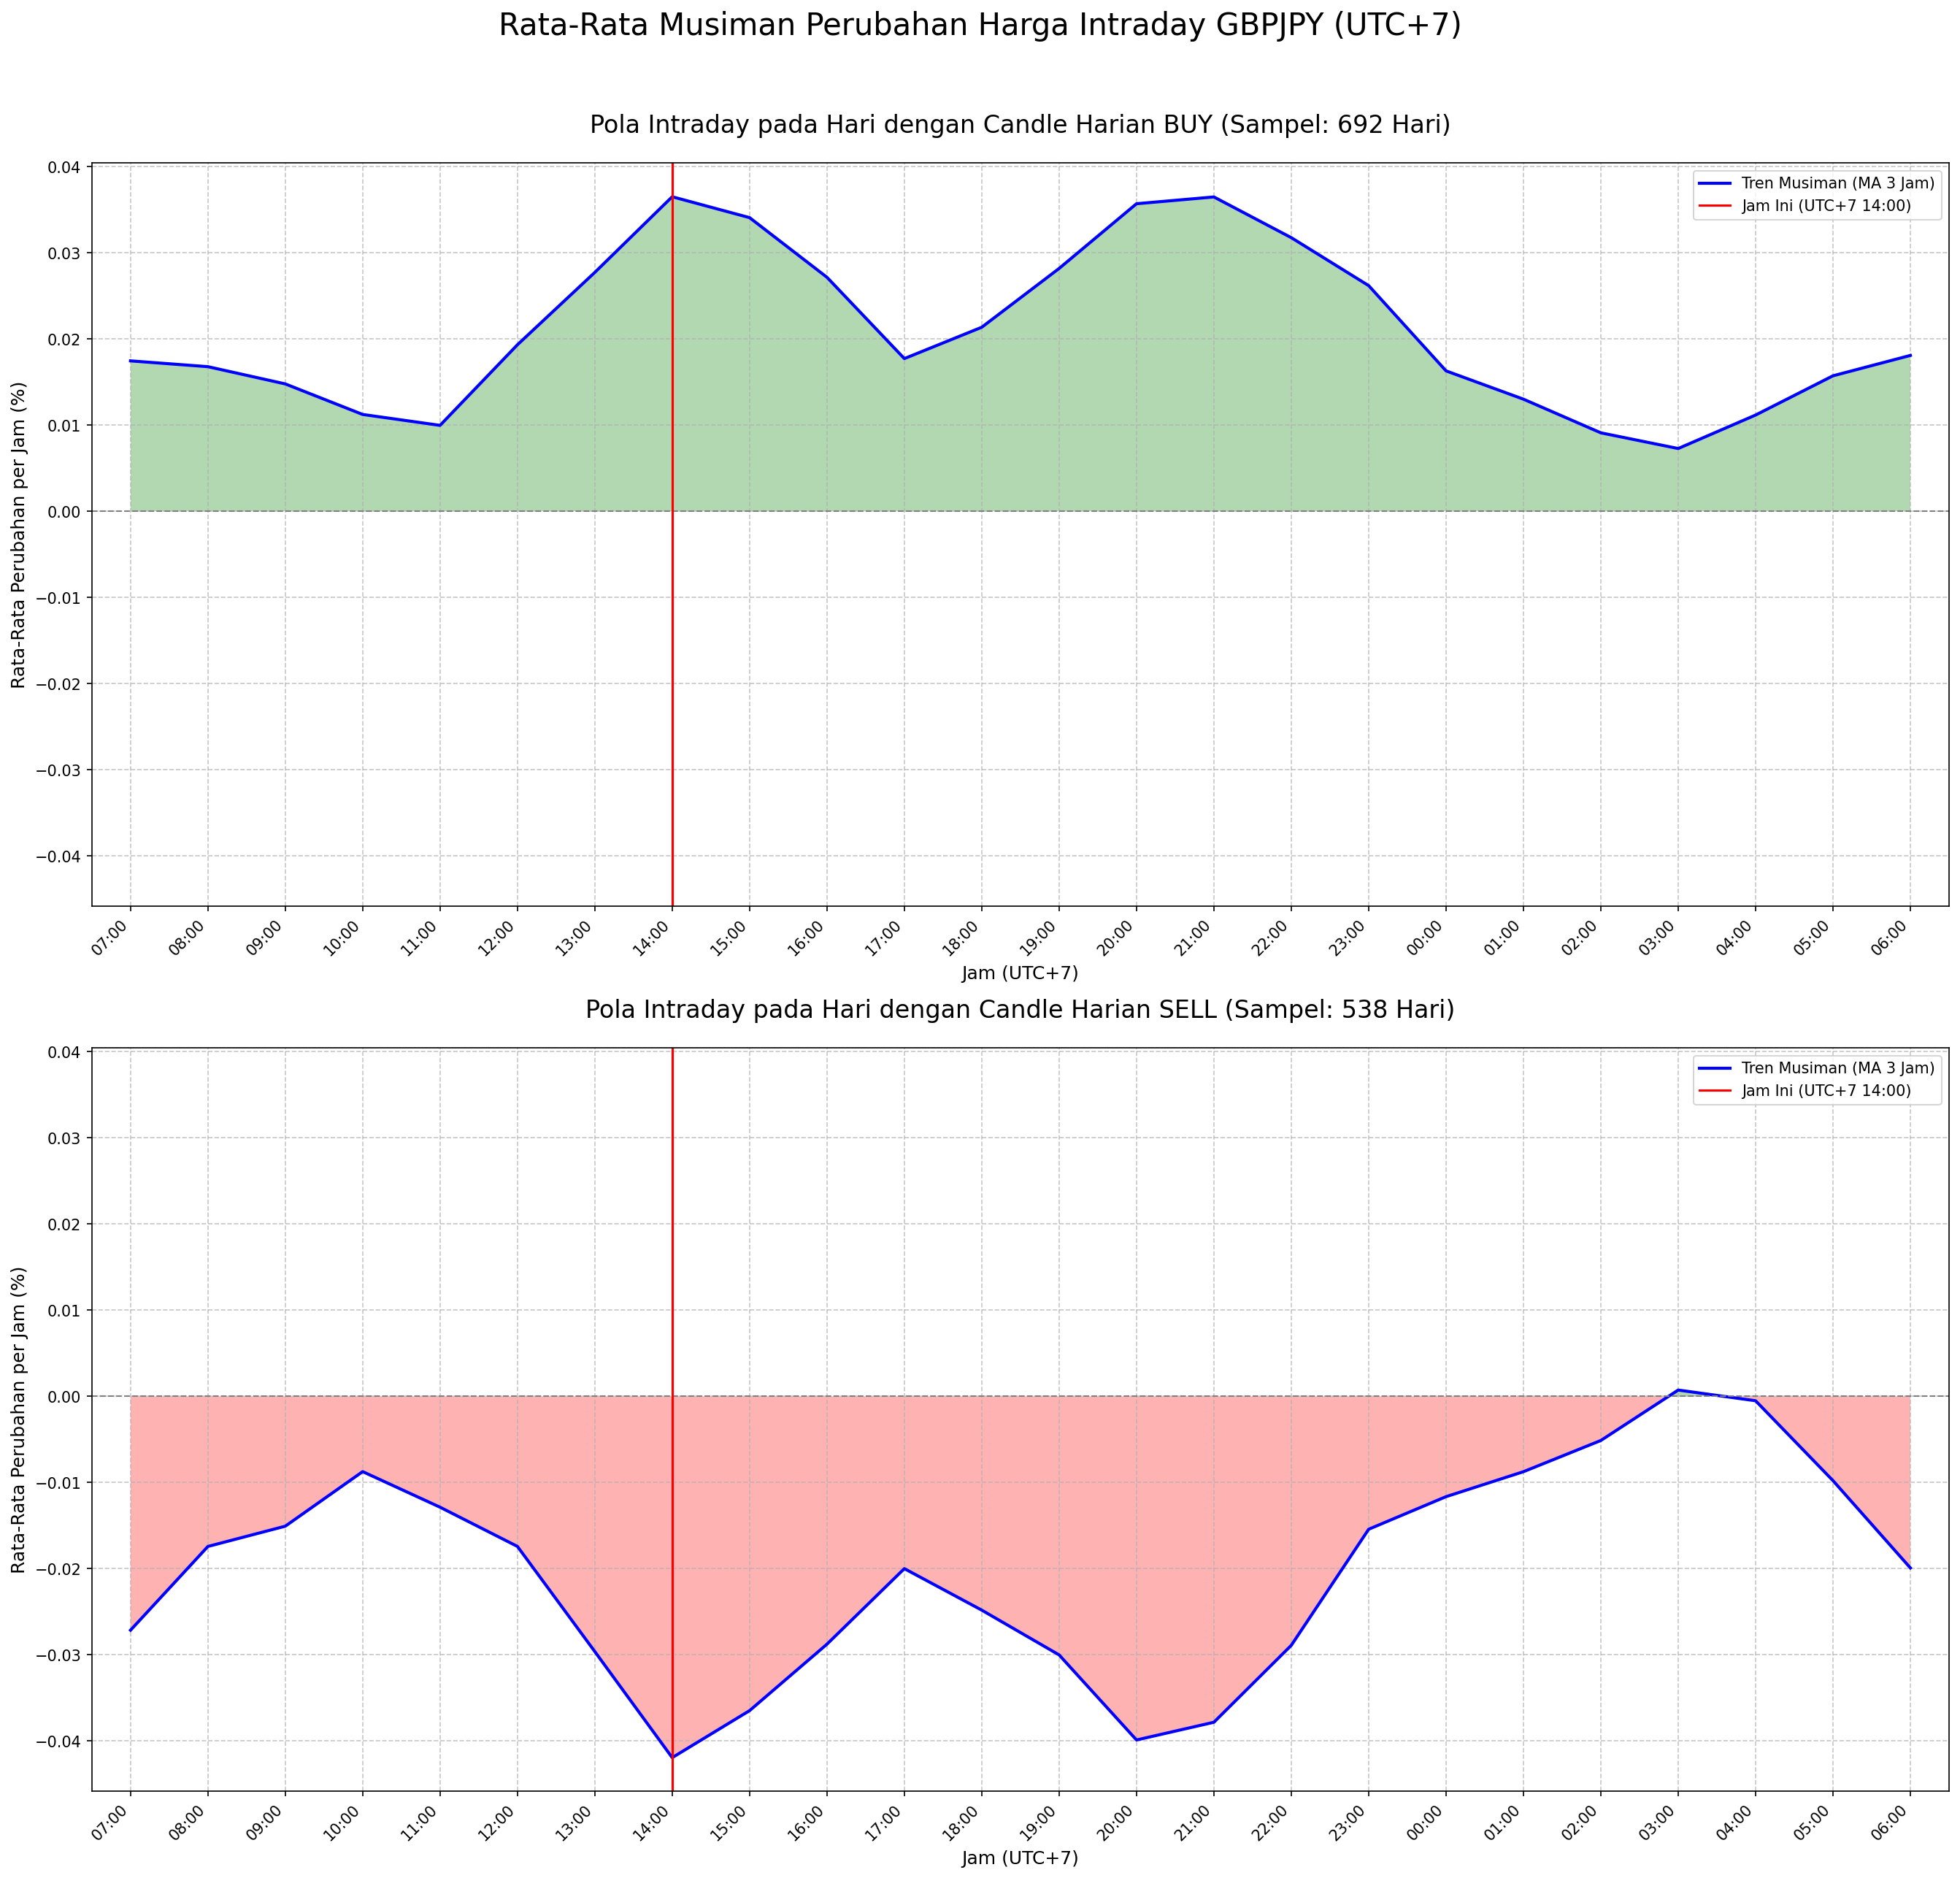


📊 Analisis Musiman Perubahan Harga Intraday untuk GBPJPY
📅 Tanggal & Waktu Analisis: 22 June 2025, 07:55:30 UTC

Jam Puncak Tekanan Beli & Jual (Berdasarkan Tren Historis)

--- Kondisi: Candle Harian BUY (Sampel: 692 Hari) ---
  Tekanan BELI terkuat terjadi pada Jam: 14:00 UTC+7 (Rata-rata: +0.0365%)
  Tekanan JUAL terkuat terjadi pada Jam: 03:00 UTC+7 (Rata-rata: 0.0073%)

--- Kondisi: Candle Harian SELL (Sampel: 538 Hari) ---
  Tekanan BELI terkuat terjadi pada Jam: 03:00 UTC+7 (Rata-rata: +0.0007%)
  Tekanan JUAL terkuat terjadi pada Jam: 14:00 UTC+7 (Rata-rata: -0.0419%)



In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
from zoneinfo import ZoneInfo

# --- Fungsi Bantuan ---
def analyze_and_plot(data, ax, title, current_hour_utc, current_hour_utc7, tick_locations, tick_labels):
    """
    Fungsi untuk menganalisis data per jam dan membuat plot seasonality.
    """
    # Hitung jumlah sampel hari unik
    num_days = data.index.normalize().nunique()
    title_with_samples = f"{title} (Sampel: {num_days} Hari)"

    if data.empty or data['pct_change'].isnull().all():
        ax.text(0.5, 0.5, 'Tidak ada data yang cukup untuk kondisi ini', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.set_title(title_with_samples, pad=20, fontsize=16)
        ax.set_xticks(ticks=tick_locations)
        ax.set_xticklabels(tick_labels, rotation=45, ha='right')
        ax.set_xlim(-0.5, 23.5)
        return None

    # 1. Hitung Perubahan Harga Rata-rata per Jam
    avg_hourly_change = data.groupby('hour_of_day_utc')['pct_change'].mean().reindex(range(24)).fillna(0)

    # 2. Hitung Tren Musiman (Moving Average)
    extended_avg = pd.concat([avg_hourly_change[-2:], avg_hourly_change, avg_hourly_change[:2]])
    seasonal_trend = extended_avg.rolling(window=3, center=True).mean().iloc[2:-2]

    # 3. Plotting
    ax.plot(seasonal_trend.index, seasonal_trend.values, color='blue', linewidth=2, label='Tren Musiman (MA 3 Jam)')
    ax.fill_between(seasonal_trend.index, seasonal_trend.values, 0, where=seasonal_trend.values >= 0, facecolor='green', interpolate=True, alpha=0.3)
    ax.fill_between(seasonal_trend.index, seasonal_trend.values, 0, where=seasonal_trend.values < 0, facecolor='red', interpolate=True, alpha=0.3)
    ax.axhline(0, color='grey', linestyle='--', linewidth=1)
    ax.axvline(x=current_hour_utc, color='red', linestyle='-', linewidth=1.5, label=f'Jam Ini (UTC+7 {current_hour_utc7:02d}:00)')
    ax.set_title(title_with_samples, pad=20, fontsize=16)
    ax.set_xlabel('Jam (UTC+7)', fontsize=12)
    ax.set_ylabel('Rata-Rata Perubahan per Jam (%)', fontsize=12)
    ax.grid(axis='both', linestyle='--', alpha=0.7)
    ax.set_xticks(ticks=tick_locations)
    ax.set_xticklabels(tick_labels, rotation=45, ha='right')
    ax.set_xlim(-0.5, 23.5)
    ax.legend(loc='upper right', fontsize=10)
    
    return seasonal_trend

def generate_summary(trend_data, original_data, condition_name):
    """
    Fungsi untuk membuat ringkasan teks dari data tren.
    """
    num_days = original_data.index.normalize().nunique()
    
    if trend_data is None or trend_data.empty:
        return [f"\n--- {condition_name} (Sampel: {num_days} Hari) ---", "Tidak ada data yang cukup untuk dianalisis."]

    max_buy_hour = trend_data.idxmax()
    max_buy_value = trend_data.max()
    max_sell_hour = trend_data.idxmin()
    max_sell_value = trend_data.min()

    summary = [
        f"\n--- {condition_name} (Sampel: {num_days} Hari) ---",
        f"  Tekanan BELI terkuat terjadi pada Jam: {(max_buy_hour + 7) % 24:02d}:00 UTC+7 (Rata-rata: +{max_buy_value:.4f}%)",
        f"  Tekanan JUAL terkuat terjadi pada Jam: {(max_sell_hour + 7) % 24:02d}:00 UTC+7 (Rata-rata: {max_sell_value:.4f}%)"
    ]
    return summary

# --- 1. Pengaturan Awal (Folder & Nama File) ---
zona_waktu_utc = ZoneInfo("UTC")
input_csv_filename = "GBPJPY_H1_202107042100_202506111000.csv"
now_utc = datetime.now(zona_waktu_utc)
now_utc_str = now_utc.strftime('%Y-%m-%d_%H-%M-%S')
output_folder = "Seasonal_Intraday_Change_Distribution"
os.makedirs(output_folder, exist_ok=True)
# summary_txt_filepath = os.path.join(output_folder, f"{now_utc_str}-{input_csv_filename.replace('.csv','')} - intraday_change_summary.txt") # Dihapus

# --- 2. Muat & Siapkan Data ---
try:
    df = pd.read_csv(input_csv_filename, delim_whitespace=True)
except FileNotFoundError:
    print(f"Error: Pastikan file '{input_csv_filename}' berada di direktori yang sama.")
    exit()

df.columns = [c.strip('<>') for c in df.columns]
df['DATETIME_UTC'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'], format='%Y.%m.%d %H:%M', utc=True)
df.set_index('DATETIME_UTC', inplace=True)
df.dropna(inplace=True)
df['hour_of_day_utc'] = df.index.hour
df['pct_change'] = ((df['CLOSE'] - df['OPEN']) / df['OPEN']) * 100
asset_name = input_csv_filename.split('_')[0]

# --- 3. Tentukan Arah Candle Harian & Pisahkan Data ---
daily_df = df['CLOSE'].resample('D').last().to_frame()
daily_df['OPEN'] = df['OPEN'].resample('D').first()
daily_df.dropna(inplace=True)
daily_df['daily_direction'] = np.sign(daily_df['CLOSE'] - daily_df['OPEN'])
df['daily_direction'] = df.index.normalize().map(daily_df['daily_direction'])

df_buy_days = df[df['daily_direction'] == 1].copy()
df_sell_days = df[df['daily_direction'] == -1].copy()

# --- 4. Persiapan untuk Plot ---
current_hour_utc = now_utc.hour
current_hour_utc7 = (current_hour_utc + 7) % 24
tick_locations = np.arange(0, 24)
tick_labels = [f'{(h + 7) % 24:02d}:00' for h in tick_locations]

# --- 5. Buat dan Tampilkan Plot Seasonality ---
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 18), dpi=150, sharey=True)
fig.suptitle(f'Rata-Rata Musiman Perubahan Harga Intraday {asset_name} (UTC+7)', fontsize=20)

# Plot untuk Buy Days
trend_buy = analyze_and_plot(df_buy_days, axes[0], 'Pola Intraday pada Hari dengan Candle Harian BUY', current_hour_utc, current_hour_utc7, tick_locations, tick_labels)
# Plot untuk Sell Days
trend_sell = analyze_and_plot(df_sell_days, axes[1], 'Pola Intraday pada Hari dengan Candle Harian SELL', current_hour_utc, current_hour_utc7, tick_locations, tick_labels)

fig.tight_layout(rect=[0, 0.03, 1, 0.96])
print("Menampilkan grafik Rata-Rata Musiman Perubahan Harga Intraday (terpisah)...")
plt.show()

# --- 6. Buat Teks Ringkasan ---
summary_lines = []
summary_lines.append(f"📊 Analisis Musiman Perubahan Harga Intraday untuk {asset_name}")
summary_lines.append(f"📅 Tanggal & Waktu Analisis: {now_utc.strftime('%d %B %Y, %H:%M:%S UTC')}")
summary_lines.append("\n" + "="*60)
summary_lines.append("Jam Puncak Tekanan Beli & Jual (Berdasarkan Tren Historis)")
summary_lines.append("="*60)

summary_buy = generate_summary(trend_buy, df_buy_days, "Kondisi: Candle Harian BUY")
summary_lines.extend(summary_buy)

summary_sell = generate_summary(trend_sell, df_sell_days, "Kondisi: Candle Harian SELL")
summary_lines.extend(summary_sell)

summary_lines.append("\n" + "="*60)
summary_text = "\n".join(summary_lines)

print("\n" + summary_text)

# with open(summary_txt_filepath, 'w', encoding='utf-8') as f:
#     f.write(summary_text)
# print(f"\nRingkasan juga telah disimpan ke file: {summary_txt_filepath}")


Menampilkan grafik Rata-Rata Musiman Perubahan Harga Intraday (terpisah)...


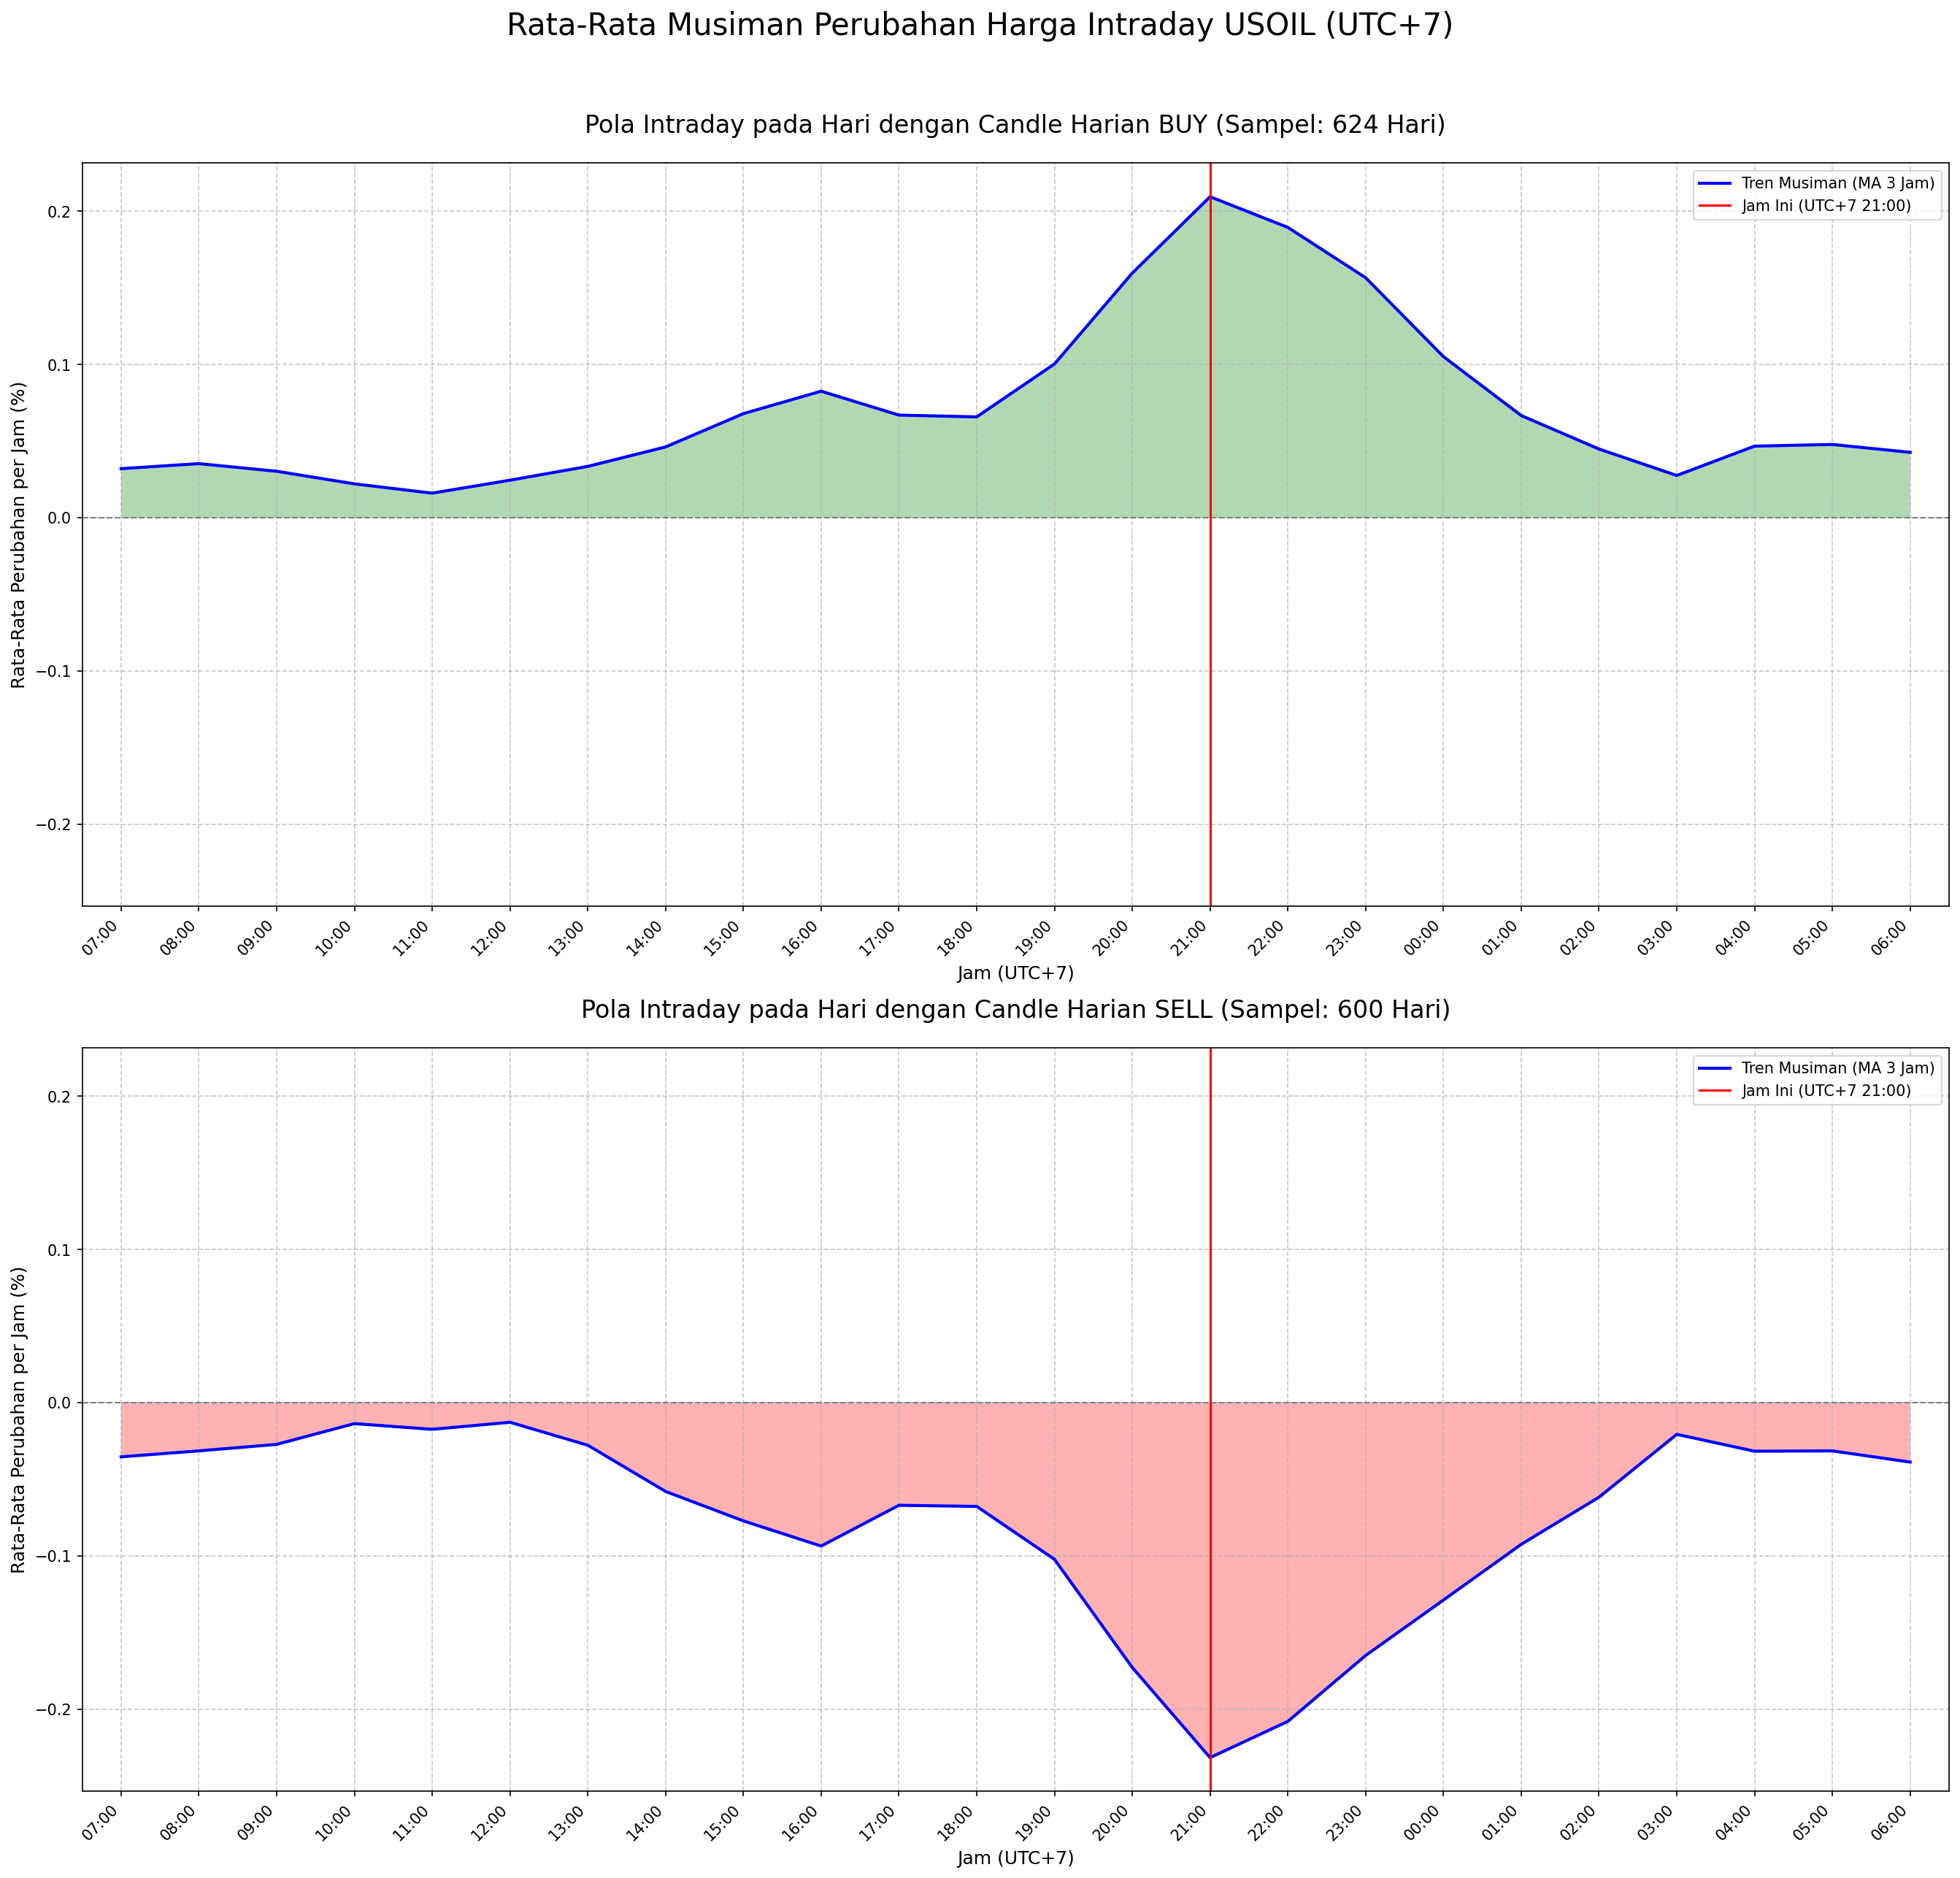


📊 Analisis Musiman Perubahan Harga Intraday untuk USOIL
📅 Tanggal & Waktu Analisis: 22 June 2025, 14:54:04 UTC

Jam Puncak Tekanan Beli & Jual (Berdasarkan Tren Historis)

--- Kondisi: Candle Harian BUY (Sampel: 624 Hari) ---
  Tekanan BELI terkuat terjadi pada Jam: 21:00 UTC+7 (Rata-rata: +0.2094%)
  Tekanan JUAL terkuat terjadi pada Jam: 11:00 UTC+7 (Rata-rata: 0.0160%)

--- Kondisi: Candle Harian SELL (Sampel: 600 Hari) ---
  Tekanan BELI terkuat terjadi pada Jam: 12:00 UTC+7 (Rata-rata: +-0.0128%)
  Tekanan JUAL terkuat terjadi pada Jam: 21:00 UTC+7 (Rata-rata: -0.2317%)



In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
from zoneinfo import ZoneInfo

# --- Fungsi Bantuan ---
def analyze_and_plot(data, ax, title, current_hour_utc, current_hour_utc7, tick_locations, tick_labels):
    """
    Fungsi untuk menganalisis data per jam dan membuat plot seasonality.
    """
    # Hitung jumlah sampel hari unik
    num_days = data.index.normalize().nunique()
    title_with_samples = f"{title} (Sampel: {num_days} Hari)"

    if data.empty or data['pct_change'].isnull().all():
        ax.text(0.5, 0.5, 'Tidak ada data yang cukup untuk kondisi ini', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.set_title(title_with_samples, pad=20, fontsize=16)
        ax.set_xticks(ticks=tick_locations)
        ax.set_xticklabels(tick_labels, rotation=45, ha='right')
        ax.set_xlim(-0.5, 23.5)
        return None

    # 1. Hitung Perubahan Harga Rata-rata per Jam
    avg_hourly_change = data.groupby('hour_of_day_utc')['pct_change'].mean().reindex(range(24)).fillna(0)

    # 2. Hitung Tren Musiman (Moving Average)
    extended_avg = pd.concat([avg_hourly_change[-2:], avg_hourly_change, avg_hourly_change[:2]])
    seasonal_trend = extended_avg.rolling(window=3, center=True).mean().iloc[2:-2]

    # 3. Plotting
    ax.plot(seasonal_trend.index, seasonal_trend.values, color='blue', linewidth=2, label='Tren Musiman (MA 3 Jam)')
    ax.fill_between(seasonal_trend.index, seasonal_trend.values, 0, where=seasonal_trend.values >= 0, facecolor='green', interpolate=True, alpha=0.3)
    ax.fill_between(seasonal_trend.index, seasonal_trend.values, 0, where=seasonal_trend.values < 0, facecolor='red', interpolate=True, alpha=0.3)
    ax.axhline(0, color='grey', linestyle='--', linewidth=1)
    ax.axvline(x=current_hour_utc, color='red', linestyle='-', linewidth=1.5, label=f'Jam Ini (UTC+7 {current_hour_utc7:02d}:00)')
    ax.set_title(title_with_samples, pad=20, fontsize=16)
    ax.set_xlabel('Jam (UTC+7)', fontsize=12)
    ax.set_ylabel('Rata-Rata Perubahan per Jam (%)', fontsize=12)
    ax.grid(axis='both', linestyle='--', alpha=0.7)
    ax.set_xticks(ticks=tick_locations)
    ax.set_xticklabels(tick_labels, rotation=45, ha='right')
    ax.set_xlim(-0.5, 23.5)
    ax.legend(loc='upper right', fontsize=10)
    
    return seasonal_trend

def generate_summary(trend_data, original_data, condition_name):
    """
    Fungsi untuk membuat ringkasan teks dari data tren.
    """
    num_days = original_data.index.normalize().nunique()
    
    if trend_data is None or trend_data.empty:
        return [f"\n--- {condition_name} (Sampel: {num_days} Hari) ---", "Tidak ada data yang cukup untuk dianalisis."]

    max_buy_hour = trend_data.idxmax()
    max_buy_value = trend_data.max()
    max_sell_hour = trend_data.idxmin()
    max_sell_value = trend_data.min()

    summary = [
        f"\n--- {condition_name} (Sampel: {num_days} Hari) ---",
        f"  Tekanan BELI terkuat terjadi pada Jam: {(max_buy_hour + 7) % 24:02d}:00 UTC+7 (Rata-rata: +{max_buy_value:.4f}%)",
        f"  Tekanan JUAL terkuat terjadi pada Jam: {(max_sell_hour + 7) % 24:02d}:00 UTC+7 (Rata-rata: {max_sell_value:.4f}%)"
    ]
    return summary

# --- 1. Pengaturan Awal (Folder & Nama File) ---
zona_waktu_utc = ZoneInfo("UTC")
input_csv_filename = "USOIL_H1_202107042200_202506111000.csv"
now_utc = datetime.now(zona_waktu_utc)
now_utc_str = now_utc.strftime('%Y-%m-%d_%H-%M-%S')
output_folder = "Seasonal_Intraday_Change_Distribution"
os.makedirs(output_folder, exist_ok=True)
# summary_txt_filepath = os.path.join(output_folder, f"{now_utc_str}-{input_csv_filename.replace('.csv','')} - intraday_change_summary.txt") # Dihapus

# --- 2. Muat & Siapkan Data ---
try:
    df = pd.read_csv(input_csv_filename, delim_whitespace=True)
except FileNotFoundError:
    print(f"Error: Pastikan file '{input_csv_filename}' berada di direktori yang sama.")
    exit()

df.columns = [c.strip('<>') for c in df.columns]
df['DATETIME_UTC'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'], format='%Y.%m.%d %H:%M', utc=True)
df.set_index('DATETIME_UTC', inplace=True)
df.dropna(inplace=True)
df['hour_of_day_utc'] = df.index.hour
df['pct_change'] = ((df['CLOSE'] - df['OPEN']) / df['OPEN']) * 100
asset_name = input_csv_filename.split('_')[0]

# --- 3. Tentukan Arah Candle Harian & Pisahkan Data ---
daily_df = df['CLOSE'].resample('D').last().to_frame()
daily_df['OPEN'] = df['OPEN'].resample('D').first()
daily_df.dropna(inplace=True)
daily_df['daily_direction'] = np.sign(daily_df['CLOSE'] - daily_df['OPEN'])
df['daily_direction'] = df.index.normalize().map(daily_df['daily_direction'])

df_buy_days = df[df['daily_direction'] == 1].copy()
df_sell_days = df[df['daily_direction'] == -1].copy()

# --- 4. Persiapan untuk Plot ---
current_hour_utc = now_utc.hour
current_hour_utc7 = (current_hour_utc + 7) % 24
tick_locations = np.arange(0, 24)
tick_labels = [f'{(h + 7) % 24:02d}:00' for h in tick_locations]

# --- 5. Buat dan Tampilkan Plot Seasonality ---
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 18), dpi=150, sharey=True)
fig.suptitle(f'Rata-Rata Musiman Perubahan Harga Intraday {asset_name} (UTC+7)', fontsize=20)

# Plot untuk Buy Days
trend_buy = analyze_and_plot(df_buy_days, axes[0], 'Pola Intraday pada Hari dengan Candle Harian BUY', current_hour_utc, current_hour_utc7, tick_locations, tick_labels)
# Plot untuk Sell Days
trend_sell = analyze_and_plot(df_sell_days, axes[1], 'Pola Intraday pada Hari dengan Candle Harian SELL', current_hour_utc, current_hour_utc7, tick_locations, tick_labels)

fig.tight_layout(rect=[0, 0.03, 1, 0.96])
print("Menampilkan grafik Rata-Rata Musiman Perubahan Harga Intraday (terpisah)...")
plt.show()

# --- 6. Buat Teks Ringkasan ---
summary_lines = []
summary_lines.append(f"📊 Analisis Musiman Perubahan Harga Intraday untuk {asset_name}")
summary_lines.append(f"📅 Tanggal & Waktu Analisis: {now_utc.strftime('%d %B %Y, %H:%M:%S UTC')}")
summary_lines.append("\n" + "="*60)
summary_lines.append("Jam Puncak Tekanan Beli & Jual (Berdasarkan Tren Historis)")
summary_lines.append("="*60)

summary_buy = generate_summary(trend_buy, df_buy_days, "Kondisi: Candle Harian BUY")
summary_lines.extend(summary_buy)

summary_sell = generate_summary(trend_sell, df_sell_days, "Kondisi: Candle Harian SELL")
summary_lines.extend(summary_sell)

summary_lines.append("\n" + "="*60)
summary_text = "\n".join(summary_lines)

print("\n" + summary_text)

# with open(summary_txt_filepath, 'w', encoding='utf-8') as f:
#     f.write(summary_text)
# print(f"\nRingkasan juga telah disimpan ke file: {summary_txt_filepath}")


Menampilkan grafik Rata-Rata Musiman Perubahan Harga Intraday (terpisah)...


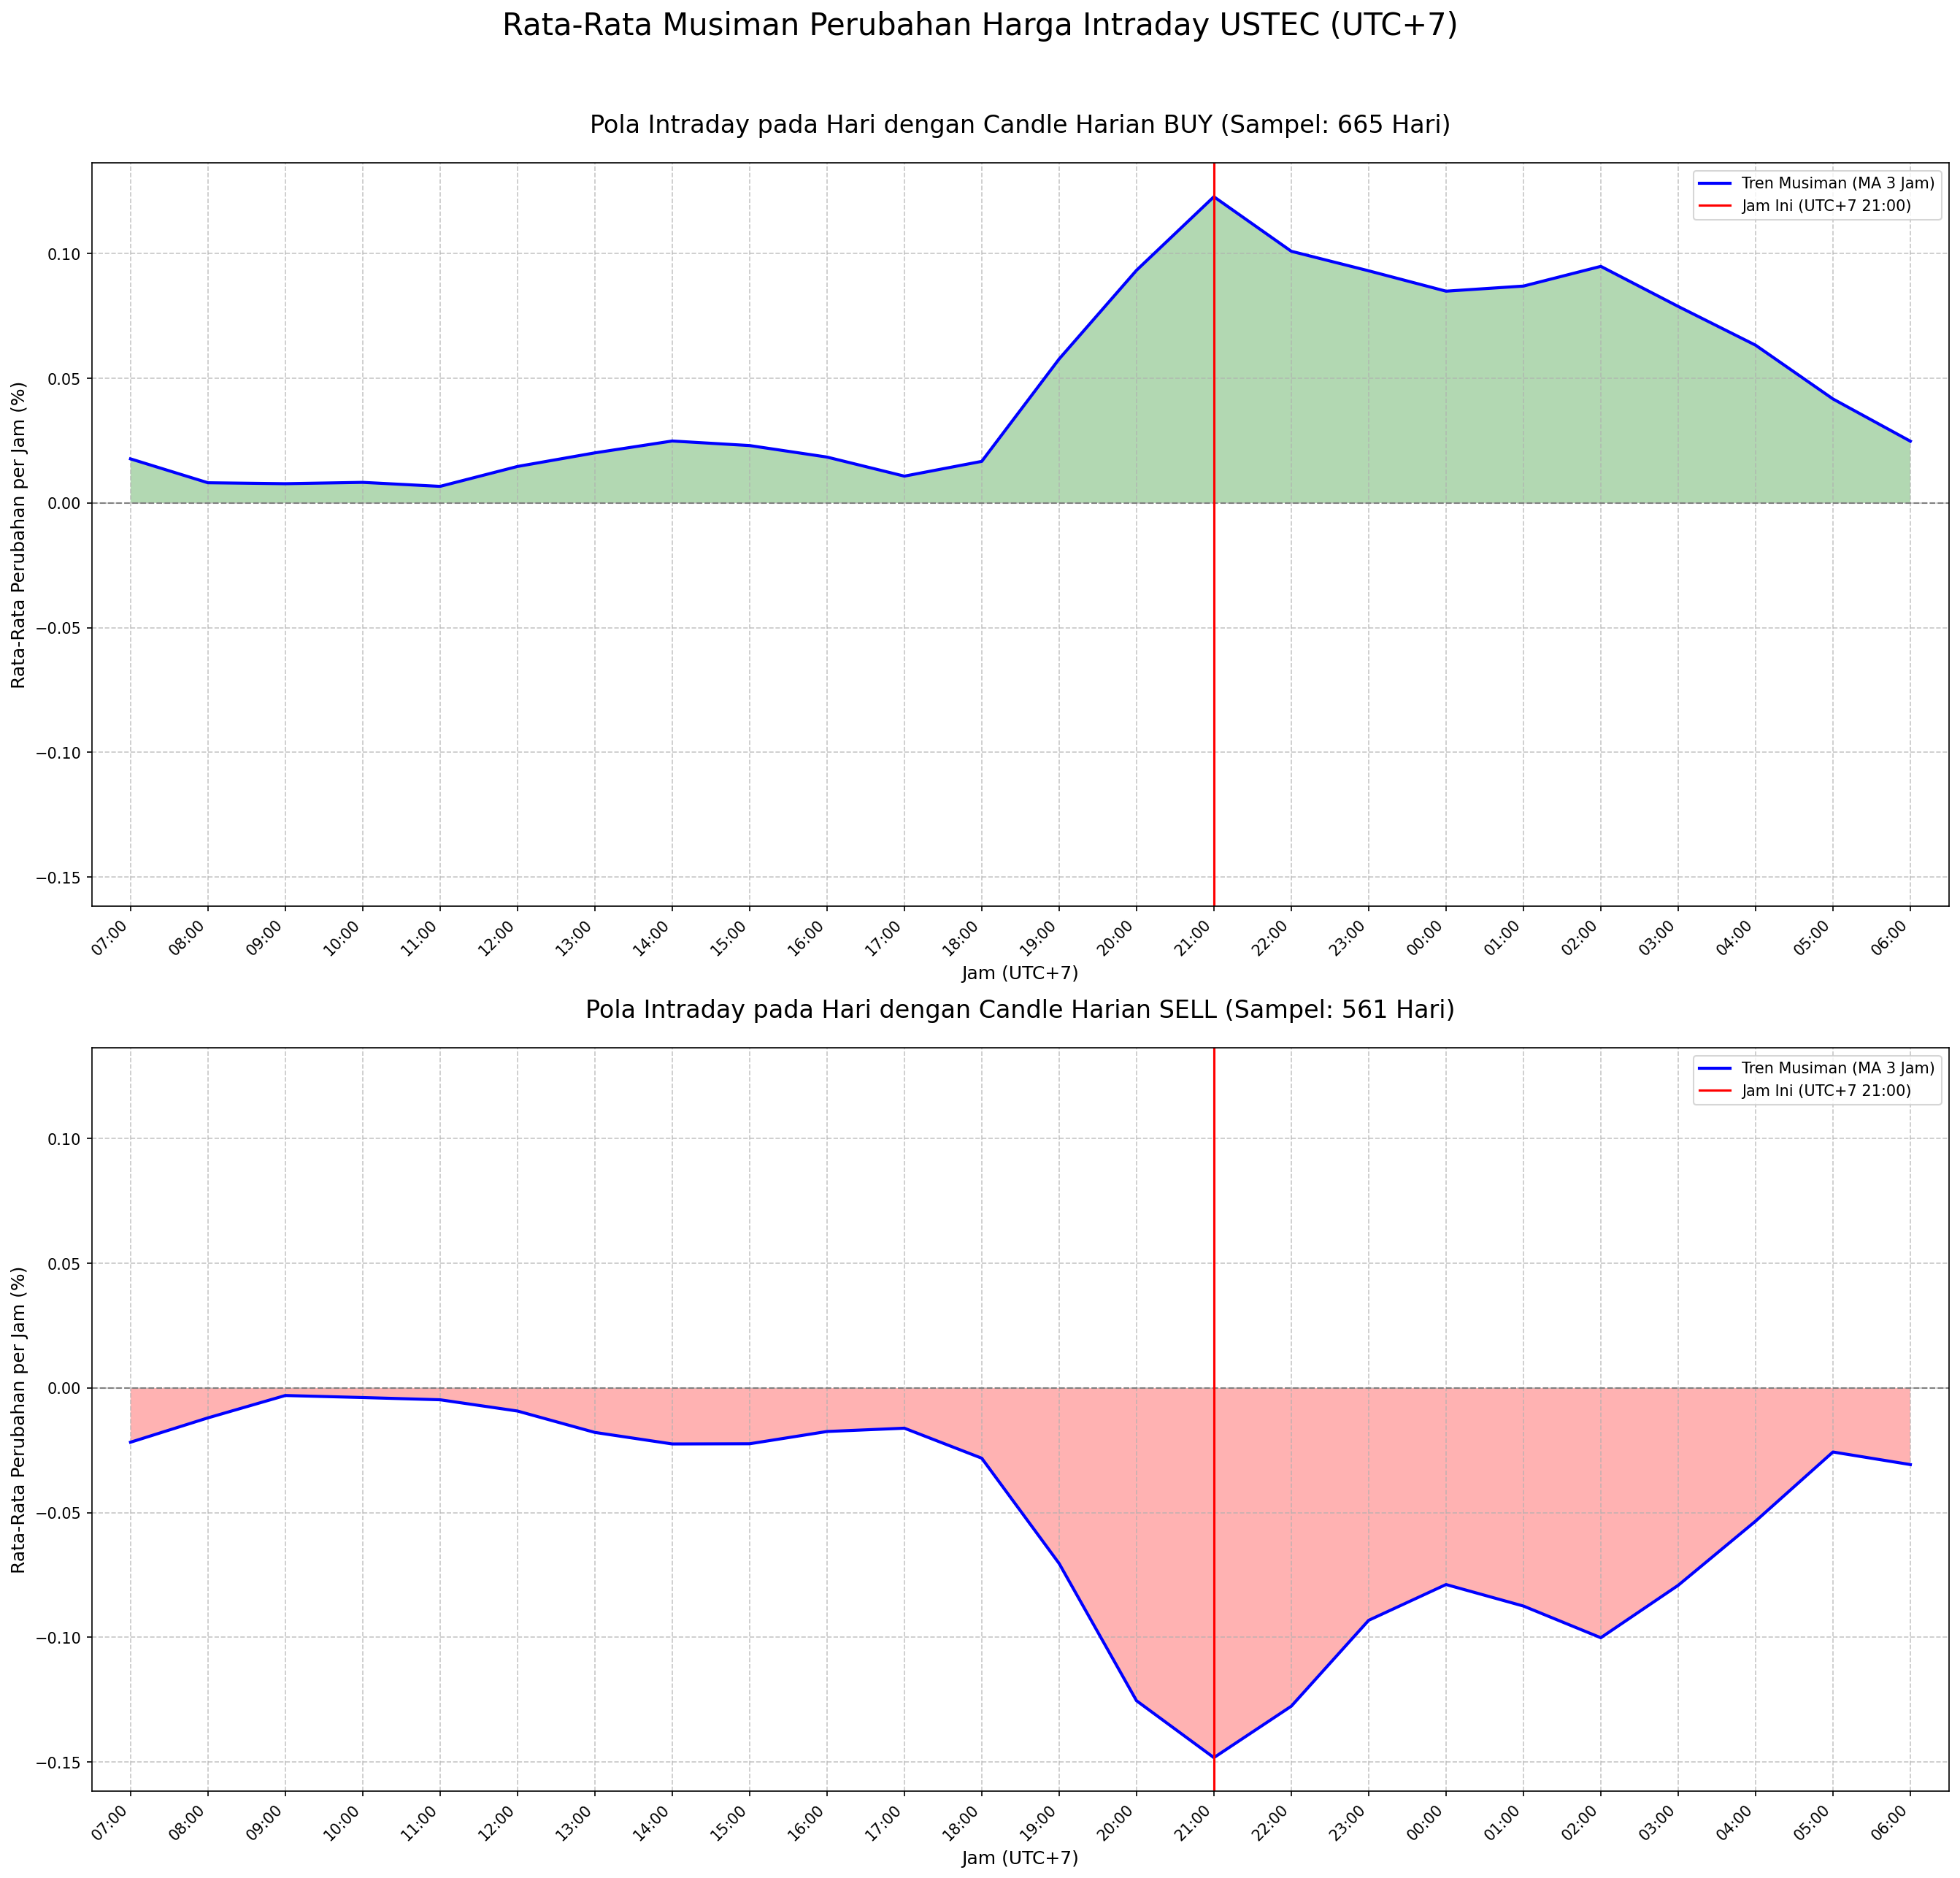


📊 Analisis Musiman Perubahan Harga Intraday untuk USTEC
📅 Tanggal & Waktu Analisis: 22 June 2025, 14:54:54 UTC

Jam Puncak Tekanan Beli & Jual (Berdasarkan Tren Historis)

--- Kondisi: Candle Harian BUY (Sampel: 665 Hari) ---
  Tekanan BELI terkuat terjadi pada Jam: 21:00 UTC+7 (Rata-rata: +0.1228%)
  Tekanan JUAL terkuat terjadi pada Jam: 11:00 UTC+7 (Rata-rata: 0.0067%)

--- Kondisi: Candle Harian SELL (Sampel: 561 Hari) ---
  Tekanan BELI terkuat terjadi pada Jam: 09:00 UTC+7 (Rata-rata: +-0.0030%)
  Tekanan JUAL terkuat terjadi pada Jam: 21:00 UTC+7 (Rata-rata: -0.1482%)



In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
from zoneinfo import ZoneInfo

# --- Fungsi Bantuan ---
def analyze_and_plot(data, ax, title, current_hour_utc, current_hour_utc7, tick_locations, tick_labels):
    """
    Fungsi untuk menganalisis data per jam dan membuat plot seasonality.
    """
    # Hitung jumlah sampel hari unik
    num_days = data.index.normalize().nunique()
    title_with_samples = f"{title} (Sampel: {num_days} Hari)"

    if data.empty or data['pct_change'].isnull().all():
        ax.text(0.5, 0.5, 'Tidak ada data yang cukup untuk kondisi ini', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.set_title(title_with_samples, pad=20, fontsize=16)
        ax.set_xticks(ticks=tick_locations)
        ax.set_xticklabels(tick_labels, rotation=45, ha='right')
        ax.set_xlim(-0.5, 23.5)
        return None

    # 1. Hitung Perubahan Harga Rata-rata per Jam
    avg_hourly_change = data.groupby('hour_of_day_utc')['pct_change'].mean().reindex(range(24)).fillna(0)

    # 2. Hitung Tren Musiman (Moving Average)
    extended_avg = pd.concat([avg_hourly_change[-2:], avg_hourly_change, avg_hourly_change[:2]])
    seasonal_trend = extended_avg.rolling(window=3, center=True).mean().iloc[2:-2]

    # 3. Plotting
    ax.plot(seasonal_trend.index, seasonal_trend.values, color='blue', linewidth=2, label='Tren Musiman (MA 3 Jam)')
    ax.fill_between(seasonal_trend.index, seasonal_trend.values, 0, where=seasonal_trend.values >= 0, facecolor='green', interpolate=True, alpha=0.3)
    ax.fill_between(seasonal_trend.index, seasonal_trend.values, 0, where=seasonal_trend.values < 0, facecolor='red', interpolate=True, alpha=0.3)
    ax.axhline(0, color='grey', linestyle='--', linewidth=1)
    ax.axvline(x=current_hour_utc, color='red', linestyle='-', linewidth=1.5, label=f'Jam Ini (UTC+7 {current_hour_utc7:02d}:00)')
    ax.set_title(title_with_samples, pad=20, fontsize=16)
    ax.set_xlabel('Jam (UTC+7)', fontsize=12)
    ax.set_ylabel('Rata-Rata Perubahan per Jam (%)', fontsize=12)
    ax.grid(axis='both', linestyle='--', alpha=0.7)
    ax.set_xticks(ticks=tick_locations)
    ax.set_xticklabels(tick_labels, rotation=45, ha='right')
    ax.set_xlim(-0.5, 23.5)
    ax.legend(loc='upper right', fontsize=10)
    
    return seasonal_trend

def generate_summary(trend_data, original_data, condition_name):
    """
    Fungsi untuk membuat ringkasan teks dari data tren.
    """
    num_days = original_data.index.normalize().nunique()
    
    if trend_data is None or trend_data.empty:
        return [f"\n--- {condition_name} (Sampel: {num_days} Hari) ---", "Tidak ada data yang cukup untuk dianalisis."]

    max_buy_hour = trend_data.idxmax()
    max_buy_value = trend_data.max()
    max_sell_hour = trend_data.idxmin()
    max_sell_value = trend_data.min()

    summary = [
        f"\n--- {condition_name} (Sampel: {num_days} Hari) ---",
        f"  Tekanan BELI terkuat terjadi pada Jam: {(max_buy_hour + 7) % 24:02d}:00 UTC+7 (Rata-rata: +{max_buy_value:.4f}%)",
        f"  Tekanan JUAL terkuat terjadi pada Jam: {(max_sell_hour + 7) % 24:02d}:00 UTC+7 (Rata-rata: {max_sell_value:.4f}%)"
    ]
    return summary

# --- 1. Pengaturan Awal (Folder & Nama File) ---
zona_waktu_utc = ZoneInfo("UTC")
input_csv_filename = "USTEC_H1_202107042200_202506111000.csv"
now_utc = datetime.now(zona_waktu_utc)
now_utc_str = now_utc.strftime('%Y-%m-%d_%H-%M-%S')
output_folder = "Seasonal_Intraday_Change_Distribution"
os.makedirs(output_folder, exist_ok=True)
# summary_txt_filepath = os.path.join(output_folder, f"{now_utc_str}-{input_csv_filename.replace('.csv','')} - intraday_change_summary.txt") # Dihapus

# --- 2. Muat & Siapkan Data ---
try:
    df = pd.read_csv(input_csv_filename, delim_whitespace=True)
except FileNotFoundError:
    print(f"Error: Pastikan file '{input_csv_filename}' berada di direktori yang sama.")
    exit()

df.columns = [c.strip('<>') for c in df.columns]
df['DATETIME_UTC'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'], format='%Y.%m.%d %H:%M', utc=True)
df.set_index('DATETIME_UTC', inplace=True)
df.dropna(inplace=True)
df['hour_of_day_utc'] = df.index.hour
df['pct_change'] = ((df['CLOSE'] - df['OPEN']) / df['OPEN']) * 100
asset_name = input_csv_filename.split('_')[0]

# --- 3. Tentukan Arah Candle Harian & Pisahkan Data ---
daily_df = df['CLOSE'].resample('D').last().to_frame()
daily_df['OPEN'] = df['OPEN'].resample('D').first()
daily_df.dropna(inplace=True)
daily_df['daily_direction'] = np.sign(daily_df['CLOSE'] - daily_df['OPEN'])
df['daily_direction'] = df.index.normalize().map(daily_df['daily_direction'])

df_buy_days = df[df['daily_direction'] == 1].copy()
df_sell_days = df[df['daily_direction'] == -1].copy()

# --- 4. Persiapan untuk Plot ---
current_hour_utc = now_utc.hour
current_hour_utc7 = (current_hour_utc + 7) % 24
tick_locations = np.arange(0, 24)
tick_labels = [f'{(h + 7) % 24:02d}:00' for h in tick_locations]

# --- 5. Buat dan Tampilkan Plot Seasonality ---
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 18), dpi=150, sharey=True)
fig.suptitle(f'Rata-Rata Musiman Perubahan Harga Intraday {asset_name} (UTC+7)', fontsize=20)

# Plot untuk Buy Days
trend_buy = analyze_and_plot(df_buy_days, axes[0], 'Pola Intraday pada Hari dengan Candle Harian BUY', current_hour_utc, current_hour_utc7, tick_locations, tick_labels)
# Plot untuk Sell Days
trend_sell = analyze_and_plot(df_sell_days, axes[1], 'Pola Intraday pada Hari dengan Candle Harian SELL', current_hour_utc, current_hour_utc7, tick_locations, tick_labels)

fig.tight_layout(rect=[0, 0.03, 1, 0.96])
print("Menampilkan grafik Rata-Rata Musiman Perubahan Harga Intraday (terpisah)...")
plt.show()

# --- 6. Buat Teks Ringkasan ---
summary_lines = []
summary_lines.append(f"📊 Analisis Musiman Perubahan Harga Intraday untuk {asset_name}")
summary_lines.append(f"📅 Tanggal & Waktu Analisis: {now_utc.strftime('%d %B %Y, %H:%M:%S UTC')}")
summary_lines.append("\n" + "="*60)
summary_lines.append("Jam Puncak Tekanan Beli & Jual (Berdasarkan Tren Historis)")
summary_lines.append("="*60)

summary_buy = generate_summary(trend_buy, df_buy_days, "Kondisi: Candle Harian BUY")
summary_lines.extend(summary_buy)

summary_sell = generate_summary(trend_sell, df_sell_days, "Kondisi: Candle Harian SELL")
summary_lines.extend(summary_sell)

summary_lines.append("\n" + "="*60)
summary_text = "\n".join(summary_lines)

print("\n" + summary_text)

# with open(summary_txt_filepath, 'w', encoding='utf-8') as f:
#     f.write(summary_text)
# print(f"\nRingkasan juga telah disimpan ke file: {summary_txt_filepath}")


Menampilkan grafik Rata-Rata Musiman Perubahan Harga Intraday (terpisah)...


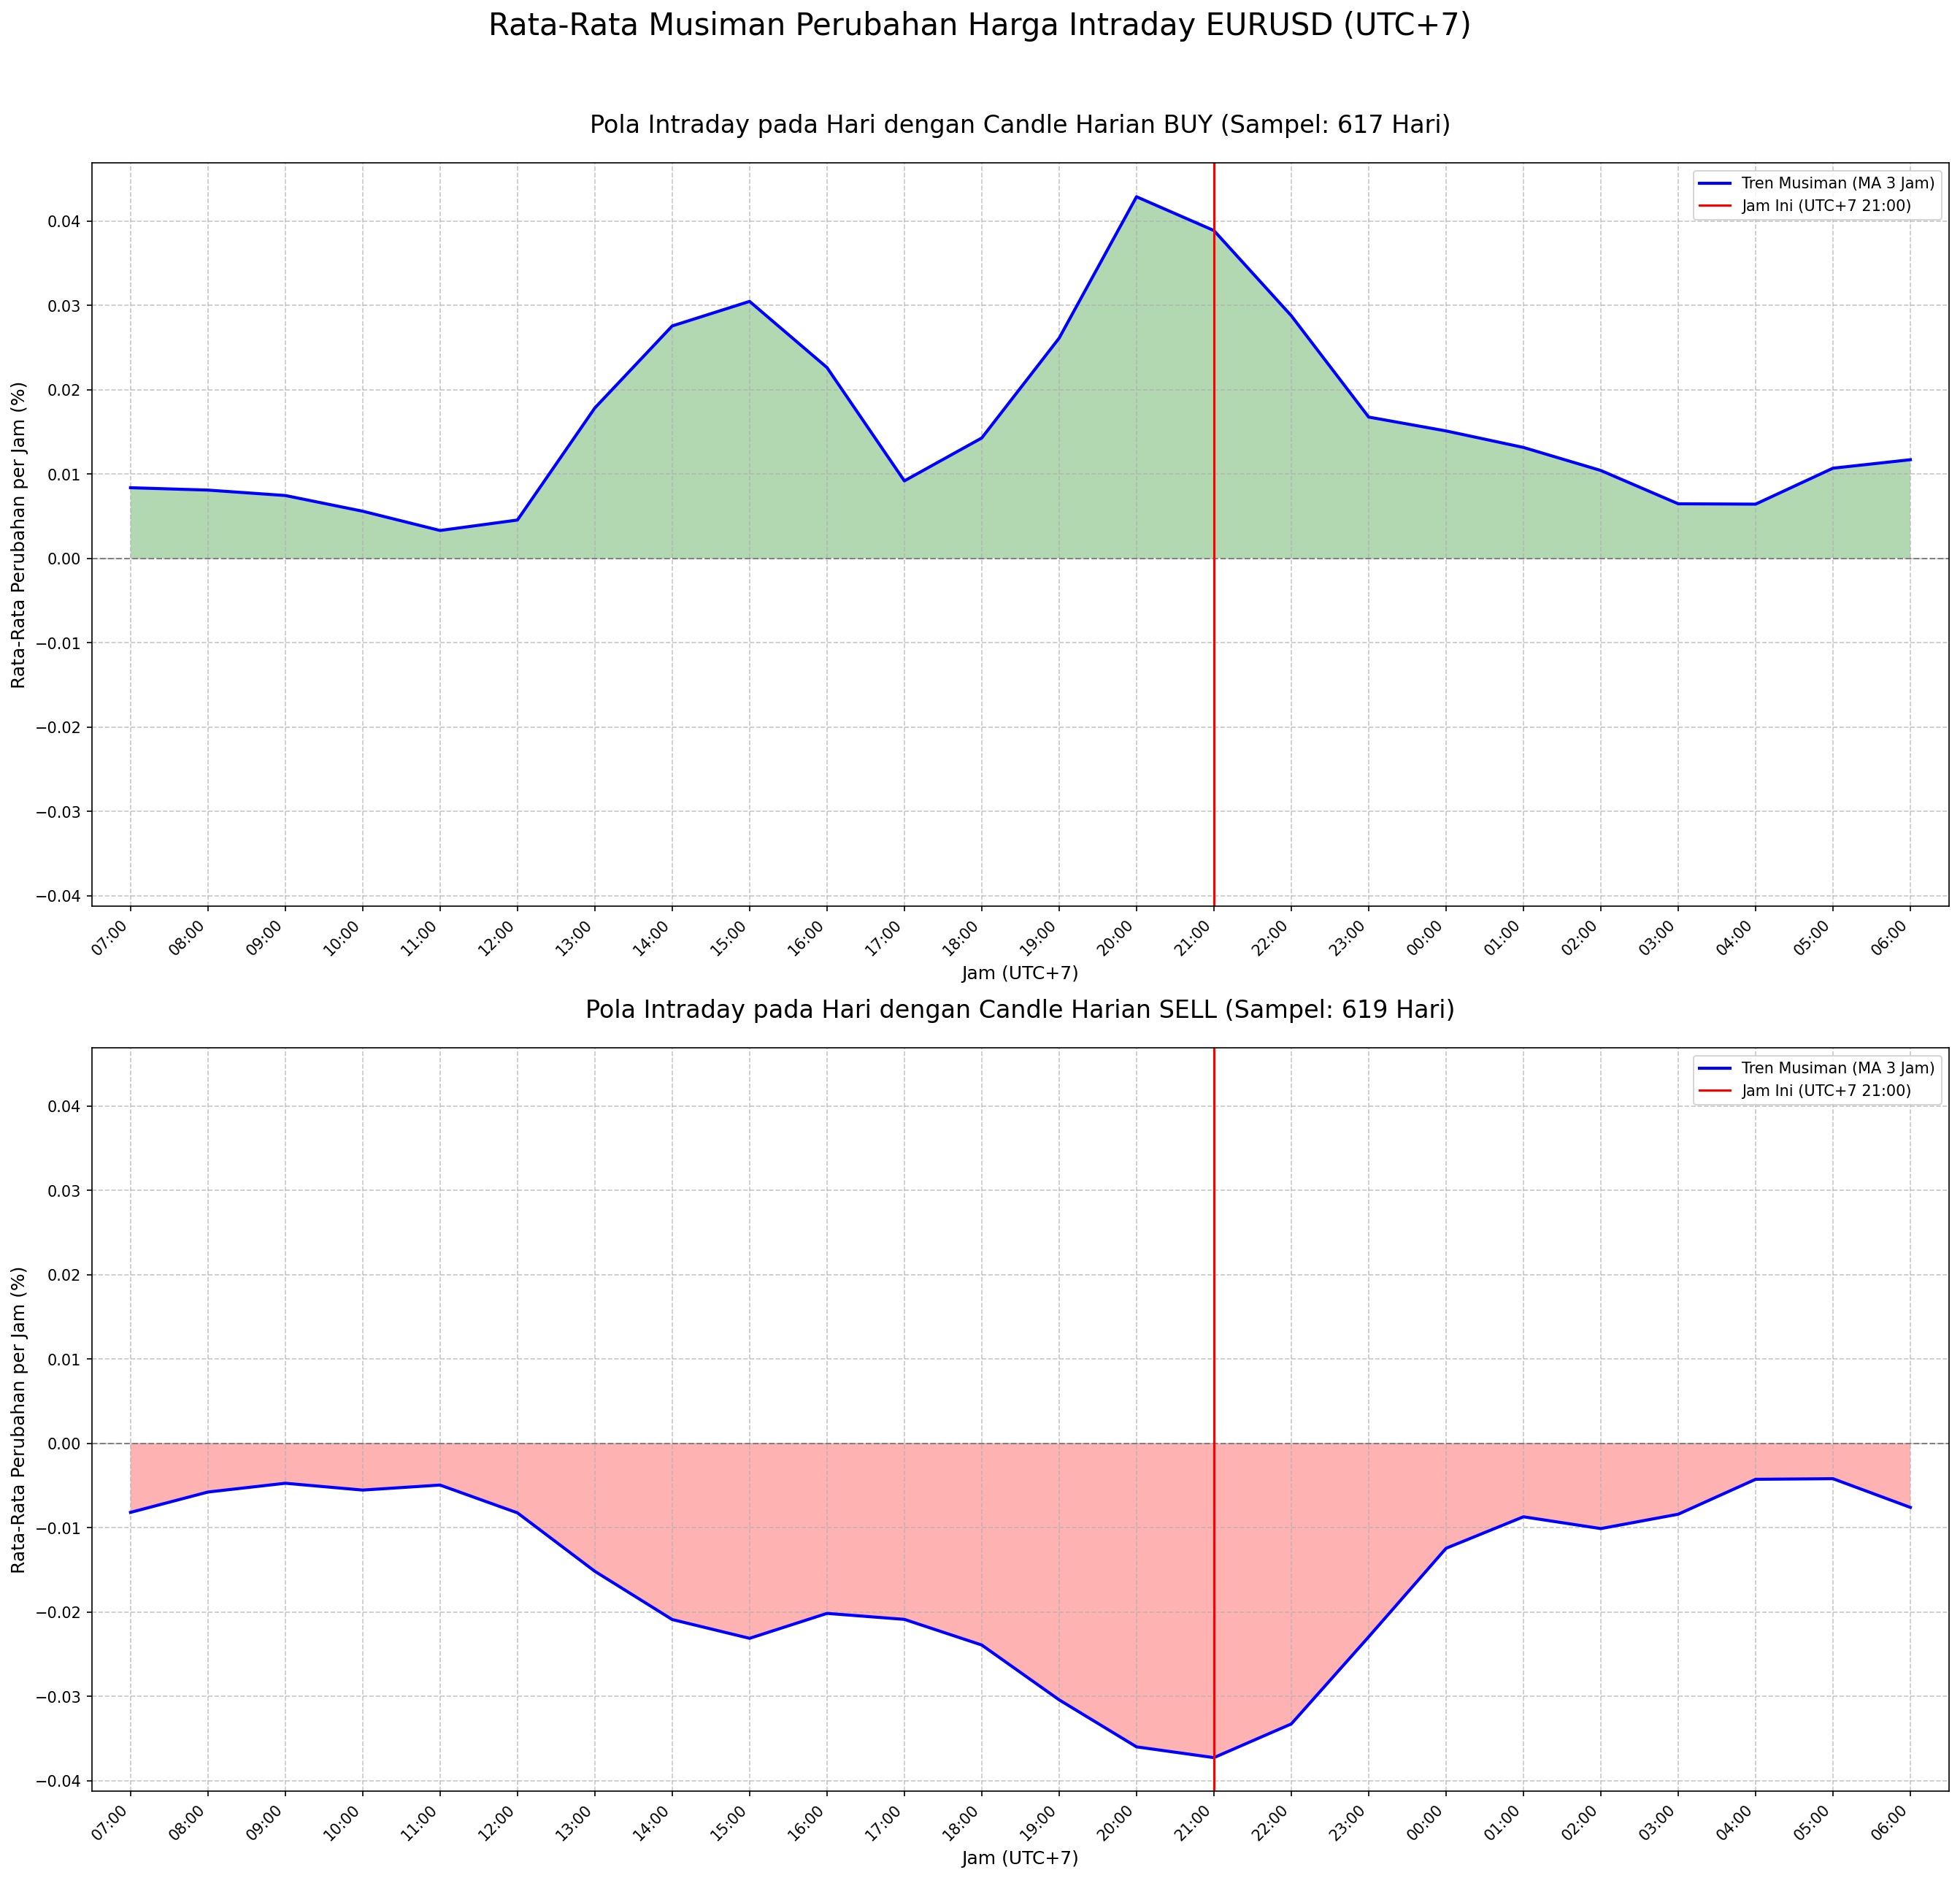


📊 Analisis Musiman Perubahan Harga Intraday untuk EURUSD
📅 Tanggal & Waktu Analisis: 22 June 2025, 14:56:15 UTC

Jam Puncak Tekanan Beli & Jual (Berdasarkan Tren Historis)

--- Kondisi: Candle Harian BUY (Sampel: 617 Hari) ---
  Tekanan BELI terkuat terjadi pada Jam: 20:00 UTC+7 (Rata-rata: +0.0429%)
  Tekanan JUAL terkuat terjadi pada Jam: 11:00 UTC+7 (Rata-rata: 0.0033%)

--- Kondisi: Candle Harian SELL (Sampel: 619 Hari) ---
  Tekanan BELI terkuat terjadi pada Jam: 05:00 UTC+7 (Rata-rata: +-0.0042%)
  Tekanan JUAL terkuat terjadi pada Jam: 21:00 UTC+7 (Rata-rata: -0.0373%)



In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
from zoneinfo import ZoneInfo

# --- Fungsi Bantuan ---
def analyze_and_plot(data, ax, title, current_hour_utc, current_hour_utc7, tick_locations, tick_labels):
    """
    Fungsi untuk menganalisis data per jam dan membuat plot seasonality.
    """
    # Hitung jumlah sampel hari unik
    num_days = data.index.normalize().nunique()
    title_with_samples = f"{title} (Sampel: {num_days} Hari)"

    if data.empty or data['pct_change'].isnull().all():
        ax.text(0.5, 0.5, 'Tidak ada data yang cukup untuk kondisi ini', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.set_title(title_with_samples, pad=20, fontsize=16)
        ax.set_xticks(ticks=tick_locations)
        ax.set_xticklabels(tick_labels, rotation=45, ha='right')
        ax.set_xlim(-0.5, 23.5)
        return None

    # 1. Hitung Perubahan Harga Rata-rata per Jam
    avg_hourly_change = data.groupby('hour_of_day_utc')['pct_change'].mean().reindex(range(24)).fillna(0)

    # 2. Hitung Tren Musiman (Moving Average)
    extended_avg = pd.concat([avg_hourly_change[-2:], avg_hourly_change, avg_hourly_change[:2]])
    seasonal_trend = extended_avg.rolling(window=3, center=True).mean().iloc[2:-2]

    # 3. Plotting
    ax.plot(seasonal_trend.index, seasonal_trend.values, color='blue', linewidth=2, label='Tren Musiman (MA 3 Jam)')
    ax.fill_between(seasonal_trend.index, seasonal_trend.values, 0, where=seasonal_trend.values >= 0, facecolor='green', interpolate=True, alpha=0.3)
    ax.fill_between(seasonal_trend.index, seasonal_trend.values, 0, where=seasonal_trend.values < 0, facecolor='red', interpolate=True, alpha=0.3)
    ax.axhline(0, color='grey', linestyle='--', linewidth=1)
    ax.axvline(x=current_hour_utc, color='red', linestyle='-', linewidth=1.5, label=f'Jam Ini (UTC+7 {current_hour_utc7:02d}:00)')
    ax.set_title(title_with_samples, pad=20, fontsize=16)
    ax.set_xlabel('Jam (UTC+7)', fontsize=12)
    ax.set_ylabel('Rata-Rata Perubahan per Jam (%)', fontsize=12)
    ax.grid(axis='both', linestyle='--', alpha=0.7)
    ax.set_xticks(ticks=tick_locations)
    ax.set_xticklabels(tick_labels, rotation=45, ha='right')
    ax.set_xlim(-0.5, 23.5)
    ax.legend(loc='upper right', fontsize=10)
    
    return seasonal_trend

def generate_summary(trend_data, original_data, condition_name):
    """
    Fungsi untuk membuat ringkasan teks dari data tren.
    """
    num_days = original_data.index.normalize().nunique()
    
    if trend_data is None or trend_data.empty:
        return [f"\n--- {condition_name} (Sampel: {num_days} Hari) ---", "Tidak ada data yang cukup untuk dianalisis."]

    max_buy_hour = trend_data.idxmax()
    max_buy_value = trend_data.max()
    max_sell_hour = trend_data.idxmin()
    max_sell_value = trend_data.min()

    summary = [
        f"\n--- {condition_name} (Sampel: {num_days} Hari) ---",
        f"  Tekanan BELI terkuat terjadi pada Jam: {(max_buy_hour + 7) % 24:02d}:00 UTC+7 (Rata-rata: +{max_buy_value:.4f}%)",
        f"  Tekanan JUAL terkuat terjadi pada Jam: {(max_sell_hour + 7) % 24:02d}:00 UTC+7 (Rata-rata: {max_sell_value:.4f}%)"
    ]
    return summary

# --- 1. Pengaturan Awal (Folder & Nama File) ---
zona_waktu_utc = ZoneInfo("UTC")
input_csv_filename = "EURUSD_H1_202107040000_202506202000.csv"
now_utc = datetime.now(zona_waktu_utc)
now_utc_str = now_utc.strftime('%Y-%m-%d_%H-%M-%S')
output_folder = "Seasonal_Intraday_Change_Distribution"
os.makedirs(output_folder, exist_ok=True)
# summary_txt_filepath = os.path.join(output_folder, f"{now_utc_str}-{input_csv_filename.replace('.csv','')} - intraday_change_summary.txt") # Dihapus

# --- 2. Muat & Siapkan Data ---
try:
    df = pd.read_csv(input_csv_filename, delim_whitespace=True)
except FileNotFoundError:
    print(f"Error: Pastikan file '{input_csv_filename}' berada di direktori yang sama.")
    exit()

df.columns = [c.strip('<>') for c in df.columns]
df['DATETIME_UTC'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'], format='%Y.%m.%d %H:%M', utc=True)
df.set_index('DATETIME_UTC', inplace=True)
df.dropna(inplace=True)
df['hour_of_day_utc'] = df.index.hour
df['pct_change'] = ((df['CLOSE'] - df['OPEN']) / df['OPEN']) * 100
asset_name = input_csv_filename.split('_')[0]

# --- 3. Tentukan Arah Candle Harian & Pisahkan Data ---
daily_df = df['CLOSE'].resample('D').last().to_frame()
daily_df['OPEN'] = df['OPEN'].resample('D').first()
daily_df.dropna(inplace=True)
daily_df['daily_direction'] = np.sign(daily_df['CLOSE'] - daily_df['OPEN'])
df['daily_direction'] = df.index.normalize().map(daily_df['daily_direction'])

df_buy_days = df[df['daily_direction'] == 1].copy()
df_sell_days = df[df['daily_direction'] == -1].copy()

# --- 4. Persiapan untuk Plot ---
current_hour_utc = now_utc.hour
current_hour_utc7 = (current_hour_utc + 7) % 24
tick_locations = np.arange(0, 24)
tick_labels = [f'{(h + 7) % 24:02d}:00' for h in tick_locations]

# --- 5. Buat dan Tampilkan Plot Seasonality ---
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 18), dpi=150, sharey=True)
fig.suptitle(f'Rata-Rata Musiman Perubahan Harga Intraday {asset_name} (UTC+7)', fontsize=20)

# Plot untuk Buy Days
trend_buy = analyze_and_plot(df_buy_days, axes[0], 'Pola Intraday pada Hari dengan Candle Harian BUY', current_hour_utc, current_hour_utc7, tick_locations, tick_labels)
# Plot untuk Sell Days
trend_sell = analyze_and_plot(df_sell_days, axes[1], 'Pola Intraday pada Hari dengan Candle Harian SELL', current_hour_utc, current_hour_utc7, tick_locations, tick_labels)

fig.tight_layout(rect=[0, 0.03, 1, 0.96])
print("Menampilkan grafik Rata-Rata Musiman Perubahan Harga Intraday (terpisah)...")
plt.show()

# --- 6. Buat Teks Ringkasan ---
summary_lines = []
summary_lines.append(f"📊 Analisis Musiman Perubahan Harga Intraday untuk {asset_name}")
summary_lines.append(f"📅 Tanggal & Waktu Analisis: {now_utc.strftime('%d %B %Y, %H:%M:%S UTC')}")
summary_lines.append("\n" + "="*60)
summary_lines.append("Jam Puncak Tekanan Beli & Jual (Berdasarkan Tren Historis)")
summary_lines.append("="*60)

summary_buy = generate_summary(trend_buy, df_buy_days, "Kondisi: Candle Harian BUY")
summary_lines.extend(summary_buy)

summary_sell = generate_summary(trend_sell, df_sell_days, "Kondisi: Candle Harian SELL")
summary_lines.extend(summary_sell)

summary_lines.append("\n" + "="*60)
summary_text = "\n".join(summary_lines)

print("\n" + summary_text)

# with open(summary_txt_filepath, 'w', encoding='utf-8') as f:
#     f.write(summary_text)
# print(f"\nRingkasan juga telah disimpan ke file: {summary_txt_filepath}")
